# Desafío Kopuru 🚀
by *Sergio Tejedor Moreno* - [STM](https://www.tejedormoreno.com)

[Enlace al desafío](https://kopuru.com/challenge/modelo-de-prediccion-de-calidad-en-el-vino-para-aidtec-solutions/?tab=tab-link_datos)

A la hora de analizar los datos deben tenerse en cuenta algunos puntos clave:

1. Cada una de las muestras (registros de las muestras) ha sido tomada de una única botella en las mismas condiciones y momento del proceso (tras el embotellado). Por tanto, todas las muestras están sujetas al mismo proceso, ya que se trata de vinos de año.
2. Es importante analizar en profundidad los datos en busca de posibles errores, que puedan afectar al modelo, y gestionarlos de forma correcta para que no afecten. Se recomienda realizar un EDA previo, que se incluirá en el informe.
3. Es importante realizar un análisis de cuáles son las variables más representativas en la decisión de la asignación de la calidad.
4. Es importante establecer cuáles son los valores máximos y mínimos admisibles para cada parámetro.
5. Aplica transformaciones de variables si fuera necesario.
6. Normaliza la información antes de realizar el modelo y toma decisiones que documentarás en el informe final.

**Objetivo**
1. Desarrollar un modelo de clasificación capaz de predecir con los datos de las muestras del 2024 cuál será la calidad de dichas muestras, tomando como referencia datos entre 2019 y 2023.
2. Desarrollar un informe explicativo donde se desarrollen las conclusiones sobre variables que más influyen en los resultados y el por qué, así como el análisis previo de los datos y sus descriptivos.

# Importaciones

In [1]:
%pip -q install icecream tensorflow scikeras sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 71.0 MB/s eta 0:00:00


In [27]:
import warnings
import multiprocessing
from functools import partial, lru_cache

import pandas as pd
from pathlib import Path
import numpy as np
from numpy.typing import NDArray
import random
import matplotlib.pyplot as plt
import joblib
import pickle
from textwrap import dedent
from tqdm.notebook import tqdm_notebook, trange
from icecream import ic
from datetime import datetime
import seaborn as sns
from typing import Literal, cast, Any
from concurrent.futures import ProcessPoolExecutor

from sklearn.base import (BaseEstimator, TransformerMixin,
                        ClassifierMixin, clone
                          )
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.ensemble import (RandomForestClassifier, IsolationForest,
                              VotingClassifier, RandomForestRegressor)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, cross_val_predict,
                                     cross_validate, StratifiedKFold,
                                     RandomizedSearchCV
                                    )
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (StandardScaler, FunctionTransformer,
                                    LabelEncoder, OneHotEncoder
                                    )
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer
                            )
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (matthews_corrcoef, precision_score,
                            accuracy_score, recall_score,
                            balanced_accuracy_score, f1_score,
                            make_scorer, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay
                            )
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import resample
from sklearn.utils.validation import check_array, check_is_fitted

from imblearn.over_sampling import SMOTE, SMOTEN, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.ensemble import (BalancedRandomForestClassifier,
                               RUSBoostClassifier,
                               EasyEnsembleClassifier)

from scipy.stats import randint, uniform, mode

import xgboost as xgb

import sweetviz as sv

import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic

# Rutas

In [3]:
interim_path = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/interim"
    )
)

raw_path = ruta_dataset = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/raw"
    )
)

processed_path = Path(
    dedent(
        "/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/data/processed"
    )
)

df_corregido_file = 'calidad_vino_AT-_train-drop_duplicates-corregir_alcohol-\
corregir_densidad.csv'
raw_data_file = "calidad_vino_AT-_train.csv"

model_path = Path(
    dedent('/content/drive/MyDrive/PYTHON/Machine Learning/Kopuru/\
AidTec Solutions Wine Quality/models')
)

# Agrupación de funciones auxiliares

## Corrección valores feature

Funciones de corrección de algunas features del dataset como **alcohol** y **densidad**

In [4]:
def filtrar_alcohol_malos(feature: pd.Series) -> pd.Series:
    """Devuelve los valores de alcohol potencialmente erróneos"""
    return feature[feature.apply(len) > 5]

def corregir_valores_alcohol(feature: pd.Series) -> pd.Series:
    """Corrige los valores de alcohol corrigiendo las comas.
    Acepta la feature y devuelve la misma feature con los
    datos corregido y cambiada a float.
    """
    # Copiamos la feature
    feature_ = feature.copy()
    # Filtramos los valores erroneos
    feature_malos = filtrar_alcohol_malos(feature_)

    # Quitamos los puntos
    if feature_malos.dtype != 'O':
        raise ValueError('La feature debe ser de tipo object')

    feature_limpio = feature_malos.str.replace('.', '', regex=False)
    # Si empieza por 8 o 9 agregamos un 0 delante
    feature_limpio[feature_limpio.str.startswith(('8', '9'))] = \
        '0' + feature_limpio
    # Añadimos el punto desde la posición 2
    feature_limpio = feature_limpio.str.slice(0, 2) + '.' + \
        feature_limpio.str.slice(1, 4)
    # Modificamos en el dataset completo
    feature_[feature_malos.index] = feature_limpio
    return feature_.astype('float64') # Devolvemos el tipo


def corregir_valores_densidad(feature: pd.Series) -> pd.Series:
    """Corrige los valores de densidad debido al mal emplazamiento
    de las comas dividiendo entre 10 hasta llegar a valores alrededor
    de 1."""
    # Copiamos la feature
    feature_ = feature.copy()
    # Filtramos los valores erroneos
    feature_malos = feature_[feature_ > 2]
    # Creamos función que procese los valores malos
    def dividir_por_diez(valor: float) -> float:
        while valor >= 10:  # Mientras el valor sea igual o mayor a 10,
            valor /= 10  # dividir entre 10.
        return valor

    feature_corregidos = feature_malos.apply(dividir_por_diez)

    # Sustituimos los corregidos
    feature_[feature_malos.index] = feature_corregidos

    return feature_



## Funciones de ploteo

Diferentes funciones para plotear las variables del dataset

In [5]:
def plotear_distribucion_variables(df: pd.DataFrame) -> None:
    """Plotea distribuciones kde"""
    num_plot_columns = 4
    # Número total de columnas en el DataFrame
    total_columns = df.shape[1]
    # Calcular número de filas de gráficos necesarias
    num_plot_rows = (total_columns + num_plot_columns - 1) // num_plot_columns
    # Crear una figura y un arreglo de ejes
    fig, axes = plt.subplots(
        nrows=num_plot_rows,
        ncols=num_plot_columns,
        figsize=(num_plot_columns * 4, num_plot_rows * 3))
    # Aplanar el arreglo de ejes para facilitar la iteración
    axes = axes.flatten()
    # Iterar sobre las columnas del DataFrame y los ejes
    for ax, column in zip(axes, df.columns):
        ax.grid(True)
        sns.histplot(df[column], ax=ax, kde=True)  # Histograma con línea de densidad
        ax.set_title(f'Distribución de {column}')
        media = df[column].mean()
        ax.axvline(media, linestyle='--', color='blue')
    # Esconder ejes extras si los hay
    for i in range(total_columns, len(axes)):
        axes[i].axis('off')

    # Ajustar automáticamente el layout
    plt.tight_layout()
    plt.show()

# Definimos la paleta de colores utilizando un mapa de colores que va de rojo
# a verde pasando por amarillo
# Utilizamos 'RdYlGn' que es el mapa de colores de rojo a verde
# pasando por amarillo
palette = sns.color_palette("RdYlGn", 7)
# Establecemos la paleta de colores
sns.set_palette(palette)
# Mapeamos los valores de la columna 'calidad' a colores para la visualización

def plot_2_variables(df: pd.DataFrame, var_x: str, var_y: str) -> None:
    """Muestra un gráfico de dispersión entre 2 variables y resalta
    en colores las valoraciones"""
    target_colors = {
        cal: pal
        for cal, pal in zip(
            df.calidad.sort_values().unique(),
            sns.color_palette().as_hex())}
    colors = df.calidad.map(target_colors)
    # Definimos una transparencia para todos los plots
    alpha= 0.6

    plt.figure(figsize=(12, 6))
    plt.scatter(df[var_x], df[var_y], c=colors, alpha=alpha);

    plt.title(f'Relación entre {var_x} y {var_y}');
    plt.xlabel(var_x);
    plt.ylabel(var_y);

    plt.grid(linestyle='--', linewidth=0.8)

    legend_patches = [
        mpatches.Patch(color=color, label=target)
        for target, color in target_colors.items()]
    plt.legend(handles=legend_patches, title='Calidad', loc='best')
    plt.show()

## Información mutua

Funciones para evaluar la MI de las features con respescto a la variable objetivo

In [6]:
def make_mi_scores(
    X: pd.DataFrame,
    y: pd.Series,
    discrete_features = "auto"
    ) -> pd.Series:
    """Crea los MI entre las variables de X e y"""
    mi_scores = mutual_info_classif(
        X,
        y,
        discrete_features=discrete_features,
        random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores:pd.Series, ax:plt.Axes) -> None:
    """Plotea los Mi scores en un histograma"""
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    ax.barh(width, scores, color='#6dcd59')
    ax.set_yticks(range(len(scores)), labels=scores.index);
    ax.set_title("Mutual Information Scores")

## Funciones para entrenar modelos

In [7]:
def train_models_basic_cross_val(X: pd.DataFrame,
                                y: pd.DataFrame | np.ndarray,
                                lista_modelos: list[BaseEstimator]=None,
                                cv: int=None
                                ) -> None:
    """Evalúa un dataset usando cross validation
    en una lista de modelos y stratifiedKfold.
    Printea varias métricas.

    Si 'cv' no se especifica calcula el mínimo
    en función del número de clases que tenga y"""

    # Calculamos los cv minimos
    if cv is None:
        if isinstance(y, np.ndarray):
            cv = min(10, min(np.bincount(y)))
        else:
            cv = min(10, min(y.values))

    skf = StratifiedKFold(n_splits=cv)
    ic(skf)

    for model in tqdm_notebook(lista_modelos):
        acc = cross_val_score(model, X,
                               y, cv=skf,
                               scoring='accuracy')
        b_acc = cross_val_score(model, X,
                               y, cv=skf,
                               scoring='balanced_accuracy')
        print(f"{model.__class__.__name__: ^60}\n \
            accuracy: {acc.mean():.4f} > {acc}\n \
            balanced accuracy: {b_acc.mean():.4f} > {b_acc}\n")

## Clasificadores personalizados

- Para tratar de mitigar el fuerta desbalanceo del dataset que veremos más adelante, se probará un clasificador propio multi etapa y compararemos su rendimiento frente a otros clasificadores

- El clasificador multi-etapa está conformado por 3 clasificadores:
1. Uno **binario** que clasifica entre clase media (5, 6, 7) y extrema
2. **Multiclase** para clasificar entre clases extremas (3, 4, 8, 9)
3. **Multiclase** para clasificar entre clases medias (5, 6 y 7)

In [8]:
class MultiStageClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 model_stage1=None,
                 model_extreme=None,
                 model_middle=None) -> None:
        """inicializa los modelos de las 3 etapas.
        Tienen que ser modelos con la firma de Scikit-Learn"""
        self.model_stage1 = model_stage1
        self.model_extreme = model_extreme
        self.model_middle = model_middle

    def fit(self,
            X: np.ndarray | pd.DataFrame,
            y: np.ndarray | pd.DataFrame
            ) -> 'MultiStageClassifier':
        self.model_stage1_ = self.model_stage1.fit(X, (y < 5) | (y > 7))
        self.model_extreme_ = self.model_extreme.fit(
            X[(y < 5) | (y > 7)], y[(y < 5) | (y > 7)]
            )
        self.model_middle_ = self.model_middle.fit(
            X[(y >= 5) & (y <= 7)], y[(y >= 5) & (y <= 7)]
            )
        return self

    def predict(self,
                X: np.ndarray | pd.DataFrame
                ) -> np.ndarray:
        # Usar check_is_fitted para asegurar que el modelo ha sido ajustado
        check_is_fitted(
            self, ['model_stage1_', 'model_extreme_', 'model_middle_']
            )

        stage1_pred = self.model_stage1_.predict(X)
        final_pred = np.where(stage1_pred,
                              self.model_extreme_.predict(X),
                              self.model_middle_.predict(X))
        return final_pred

Clasificador por votación de la mayoría que acepte modelos pre entrenados. Es especialmente importante este hecho ya que la idea será que acepte modelos que hayan sido entrenados sobre datasets tratados de formas distintas. Por ejemplo algunos con dataset resampleados y otros no, etc.

In [9]:
class MajorityClassifier:
    """Clasificador que predice por votación hard (labels)
    o sodft (predicciones) de entre los clasificadores
    que posea."""
    def __init__(self,
                 models_list: list[BaseEstimator],
                 voting: Literal['hard', 'soft']='hard',
                 ) -> None:
        """Recibe una lista de clasificadores
        entrenados.
        Al llamar a predict para cada
        predicción saca la más votada.

        Permite hard: devuelve la clase más votada por mayoria
                soft: utiliza la media de las predicciones de cada clase
                para sacar la clase final."""
        self.models = models_list
        self.voting = voting

        # Validamos que tengan método predict
        for model in models_list:
            if not hasattr(model, 'predict'):
                raise ValueError(f'El modelo {model.__class__.__name__} no es válido')

    def predict_proba(self,
                      X: np.ndarray) -> np.ndarray:
        # Obtener las probabilidades promedio de cada clase para todos los modelos
        mean_proba = np.zeros((X.shape[0], self.models[0].classes_.shape[0]))
        for model in self.models:
            proba = model.predict_proba(X)
            mean_proba += proba
        mean_proba /= len(self.models)
        return mean_proba

    def predict(self,
                X: np.ndarray
                ) -> np.ndarray:
        # Usar check_is_fitted para asegurar que el modelo ha sido ajustado
        [check_is_fitted(model) for model in self.models]

        if self.voting == 'soft':
            # Predecir la clase con la mayor probabilidad promedio
            mean_proba = self.predict_proba(X)
            return self.models[0].classes_[np.argmax(mean_proba, axis=1)]

        # Creamos un array de predicciones
        self.preds = np.zeros(shape=(len(X), len(self.models)))
        # Poblamos las predicciones
        for col, model in enumerate(self.models):
            predicciones = model.predict(X)
            self.preds[:, col] = predicciones

        ic(self.preds.shape)
        # Votamos entre todas las predicciones por fila
        self.preds = mode(self.preds, axis=1).mode.astype('int32')

        return self.preds

Wrapper y Mixin para poder Serializar y Deserializar con Joblib cualquier clasificador de scikit-learn. Lo usaremos más adelante para cargar o guardar modelos de forma más rápida

In [28]:
class SerializableMixin:
    """Clase que implementa el método save
    para serializar un modelo"""

    def save(self, model_path: Path) -> None:
        """Serializa el modelo usando joblib"""
        with open(model_path, "wb") as f:
            joblib.dump(self, f)


class DeserializableMixin(SerializableMixin):
    """Clase para cargar y deserializar
    un modelo guardado

    Parameters
    ----------
    SerializableMixin : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    @classmethod
    def load(cls, model_path: str | Path) -> "SerializableClassifier":
        with open(model_path, "rb") as f:
            classifier = cast(SerializableClassifier, joblib.load(f))
        return classifier


class SerializableTransformer(BaseEstimator, TransformerMixin, DeserializableMixin):
    """Wrapper de un transformador
    para hacerlo serializable

    Parameters
    ----------
    BaseEstimator : _type_
        _description_
    TransformerMixin : _type_
        _description_
    DeserializableMixin : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    def __init__(self, transformer: TransformerMixin) -> None:
        super().__init__()
        self.transformer = transformer

    def fit(self, y: NDArray[np.float64] | pd.DataFrame) -> "SerializableTransformer":
        self.transformer.fit(y)
        return self

    def transform(self, y: NDArray[np.float64] | pd.DataFrame) -> NDArray[np.int_]:
        check_is_fitted(self.transformer)
        transformation_array: NDArray[np.int_] = self.transformer.transform(y)
        return transformation_array

    def inverse_transform(
        self, y: NDArray[np.float64] | pd.DataFrame
    ) -> NDArray[np.int_]:
        check_is_fitted(self.transformer)
        transformation_array: NDArray[np.int_] = self.transformer.inverse_transform(y)
        return transformation_array

    def __getattr__(self, attr: Any) -> Any:
        """Delega atributos al clasificador subyacente si no se encuentran en 'self'."""
        return getattr(self.transformer, attr)

# Carga del Dataset

In [11]:
df_raw = pd.read_csv(raw_path / raw_data_file, index_col=0)
df = df_raw.copy()

In [ ]:
dict(enumerate([str(i) for i in range(3, 10)], start=3))

{3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}

# Equilibrado del Dataset

- Lo primero que haremos será mirar la distribución de nuestros labels. Al tratarse de un problema de clasificación múltiple, es importante para un correcto aprendizaje de los modelos que los valores de la variable objetivo a predecir estén repartidos de forma equilibrada

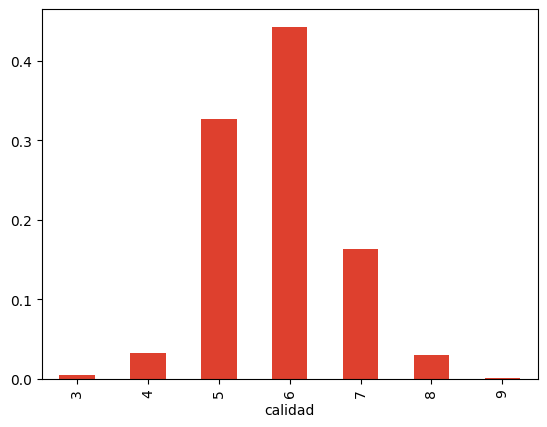

In [ ]:
df['calidad'].value_counts(normalize=True).sort_index().plot(kind='bar');

Podemos apreciar que las clases medias (5, 6 y 7) están mucho más representadas que las clases extremas (3, 4, 8 y 9)
- Intentaremos algunas estrategias de re-muestreo para comprobar si se aumenta la precisión de los modelos
- También tendremos en cuenta estos datos a la hora de evaluar las métricas de los modelos

# EDA con sweetviz

                                             |          | [  0%]   00:00 -> (? left)


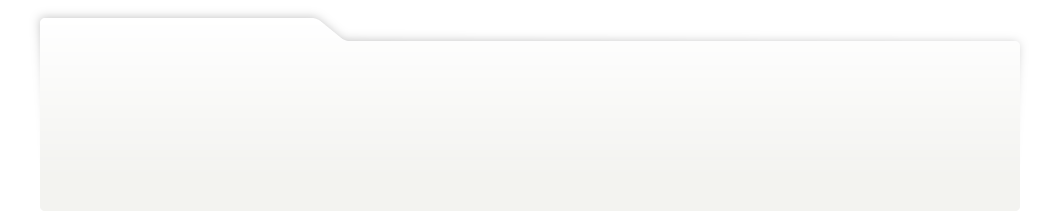
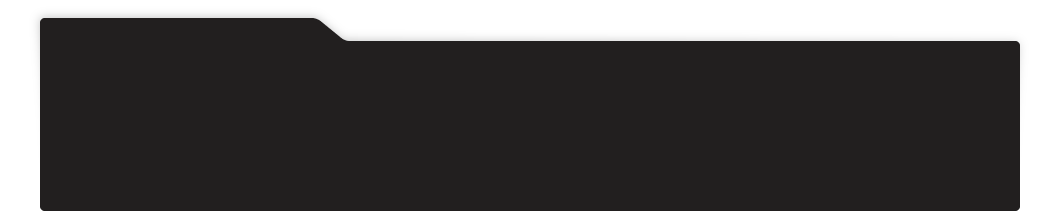
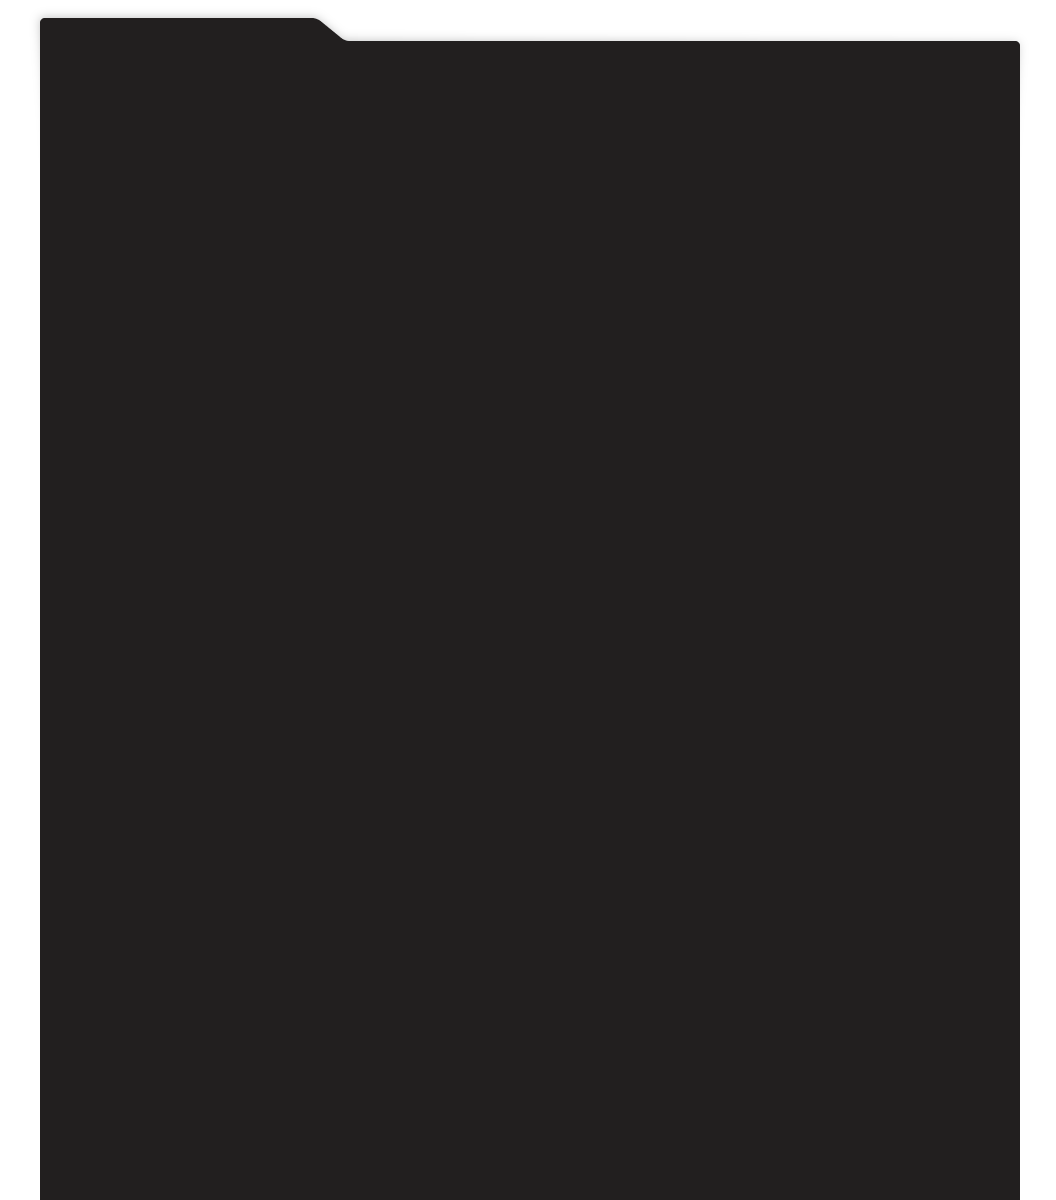
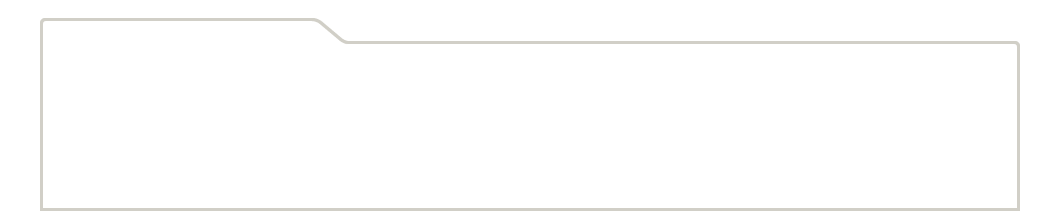
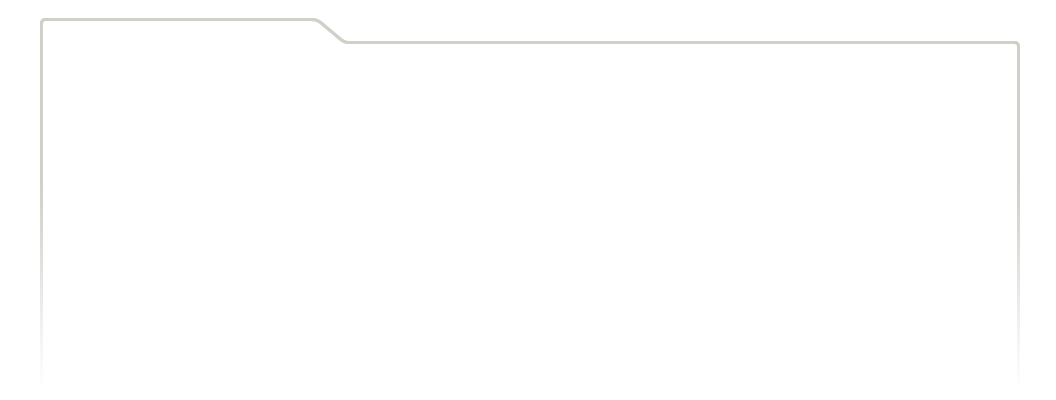
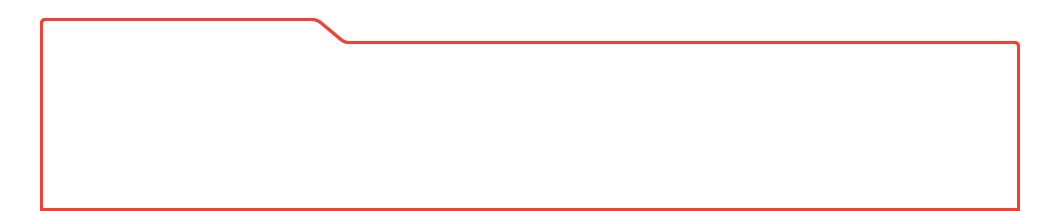
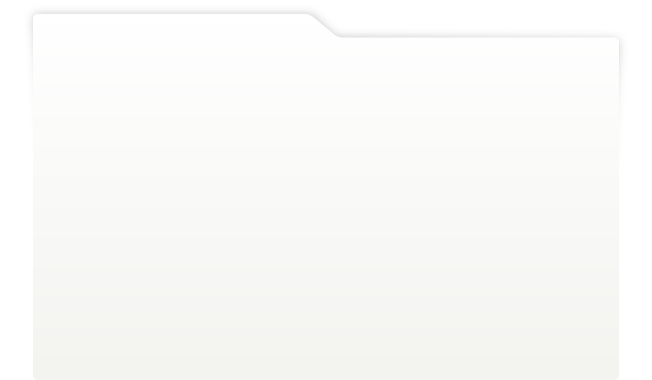
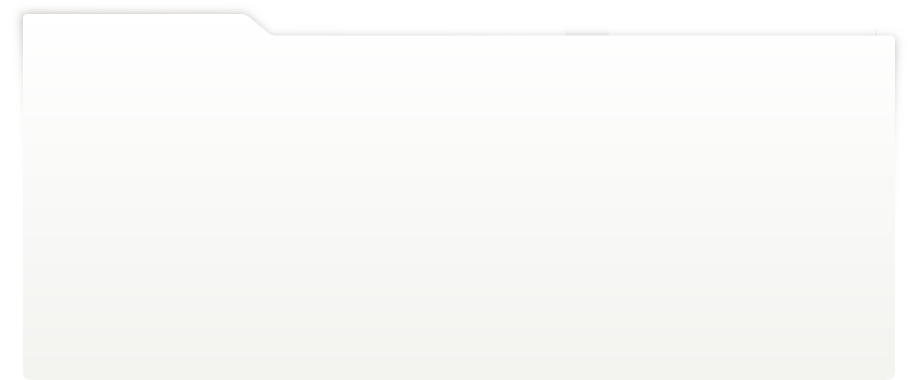
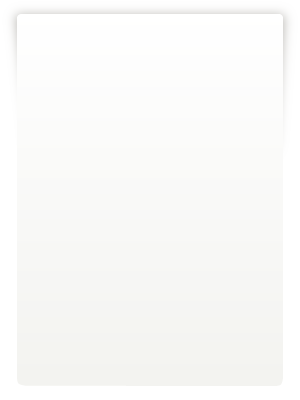
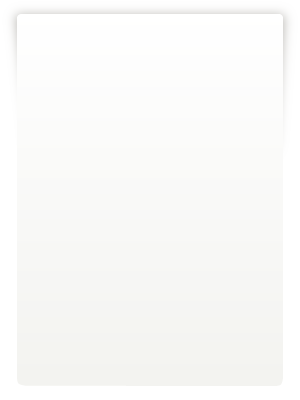
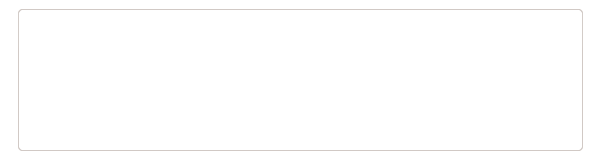
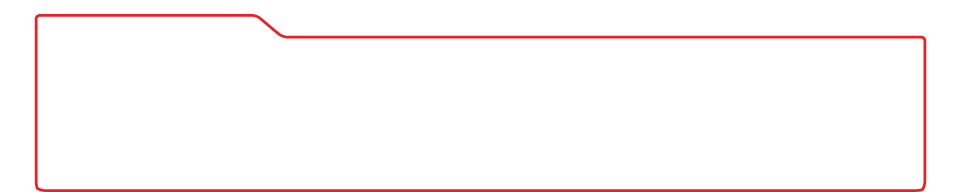
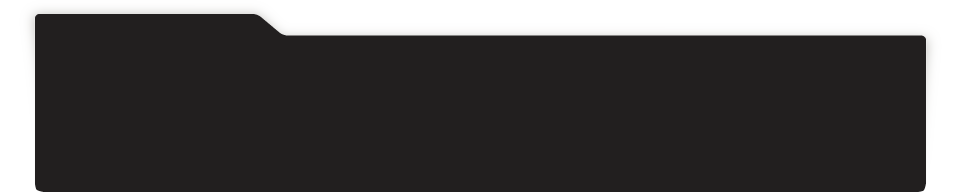
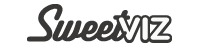
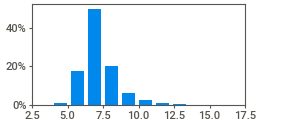
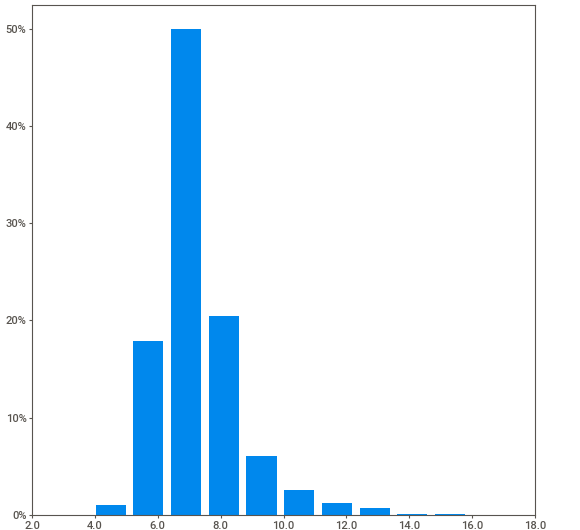
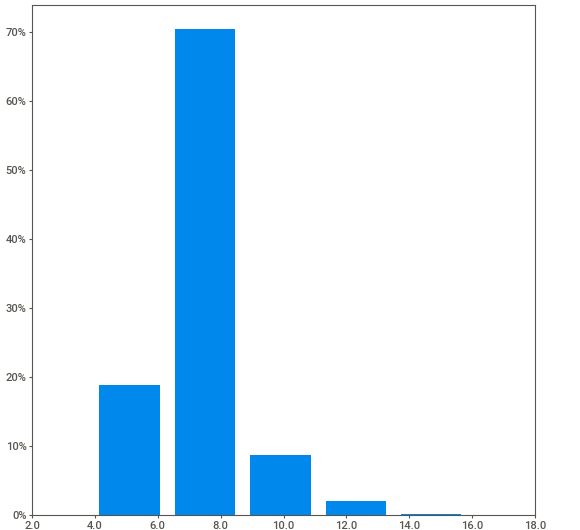
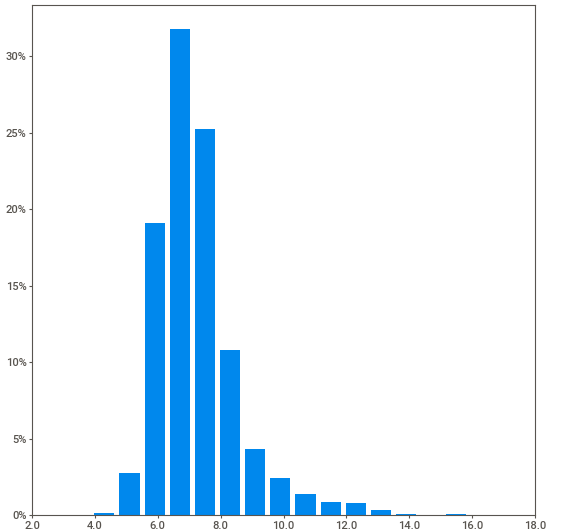
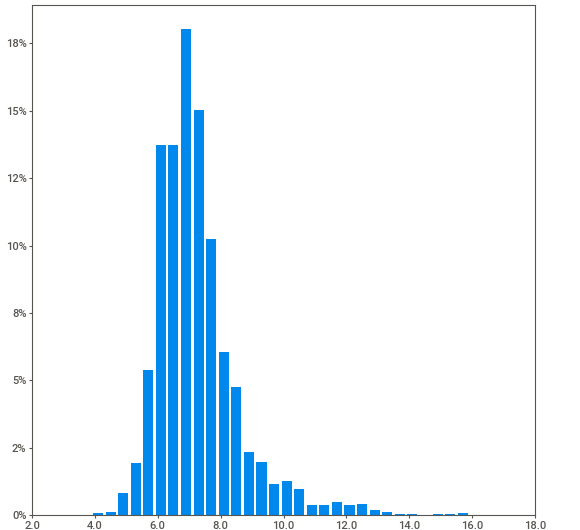
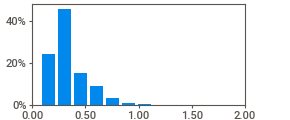
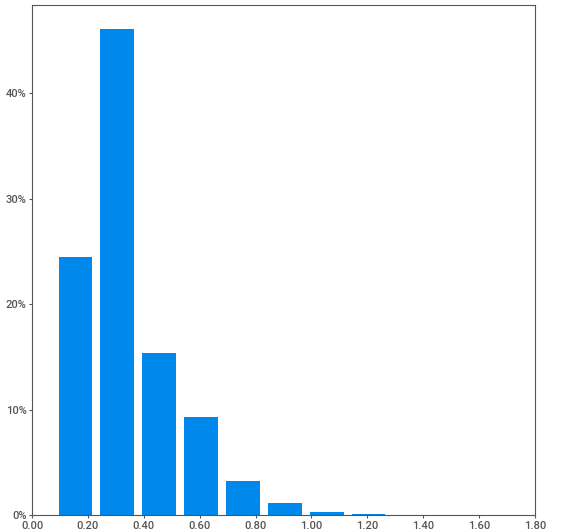
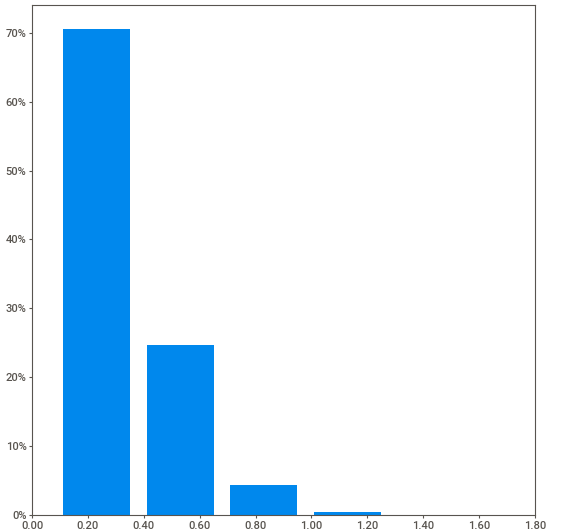
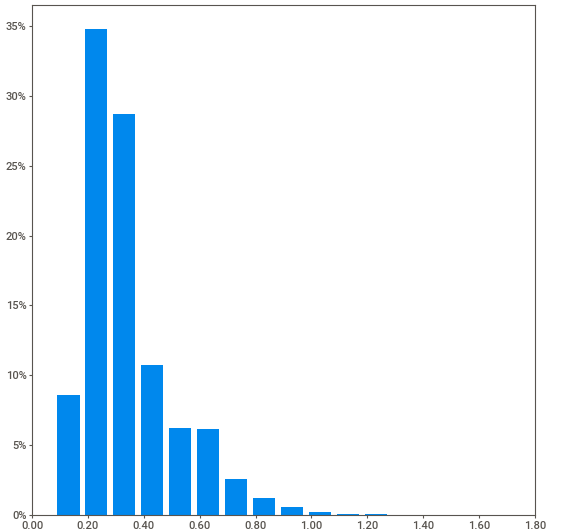
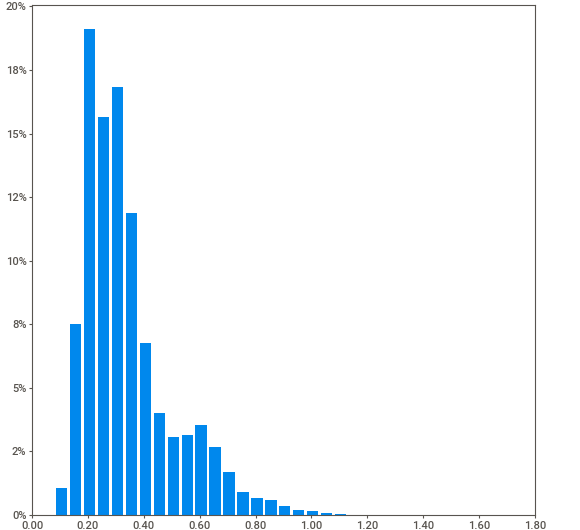
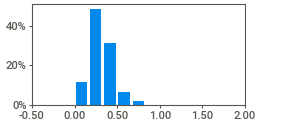
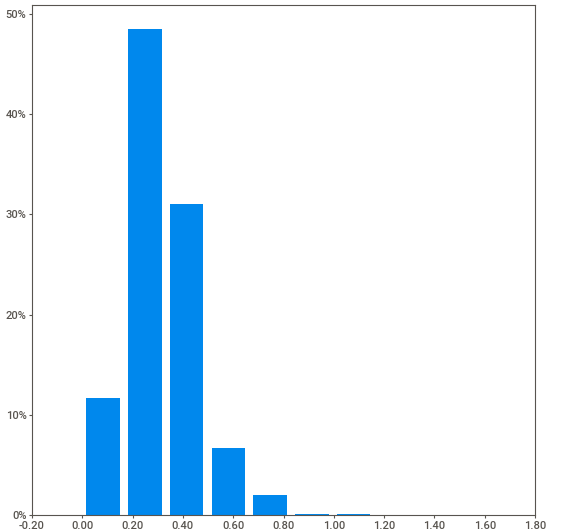
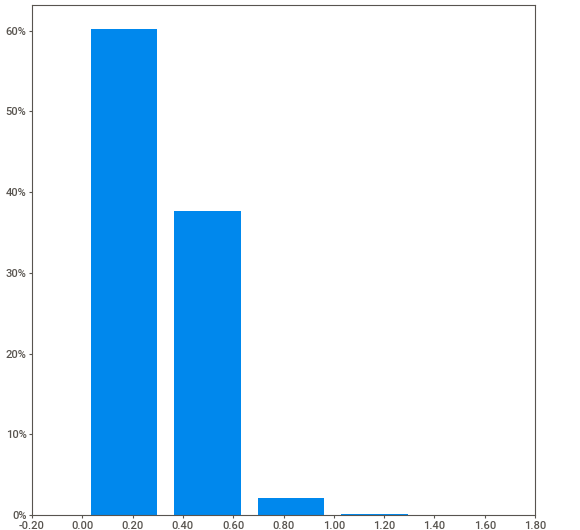
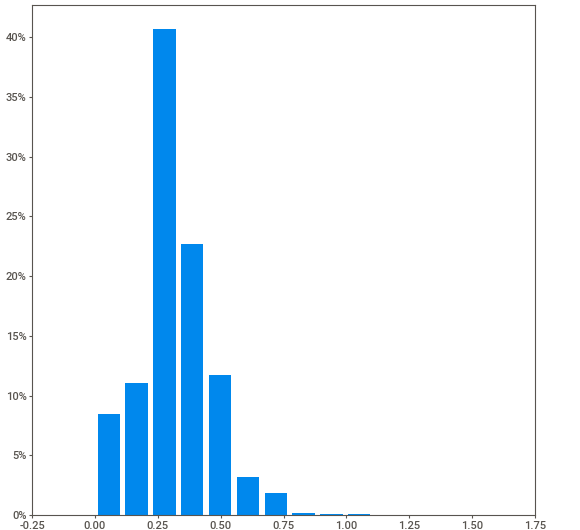
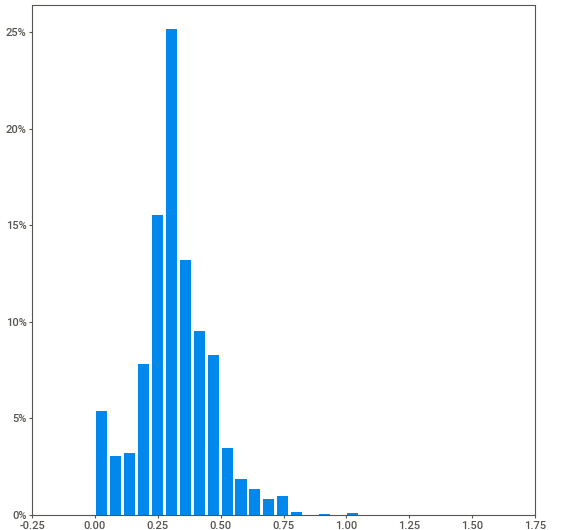
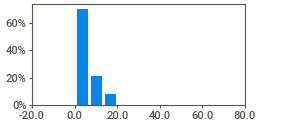
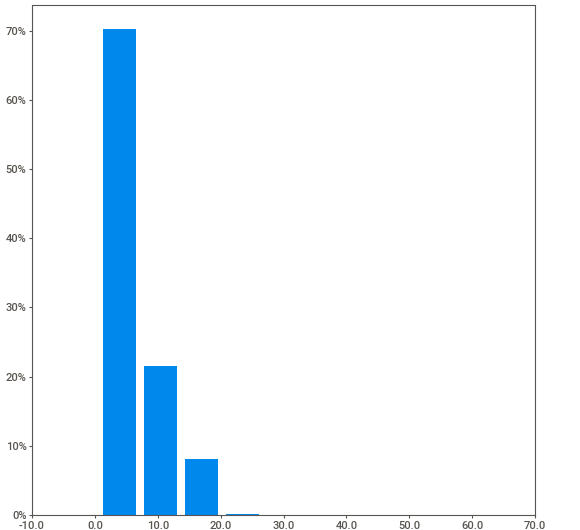
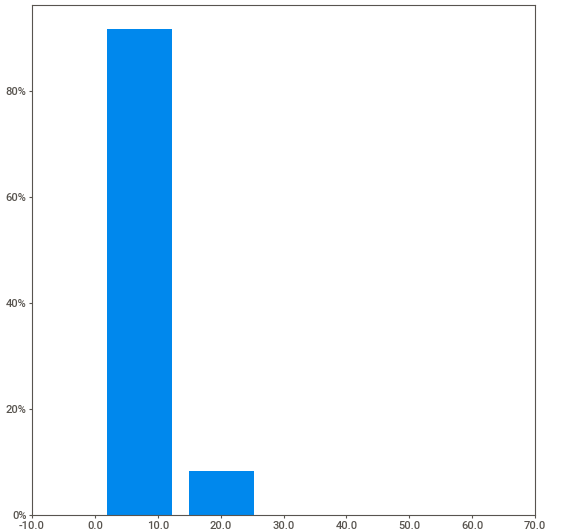
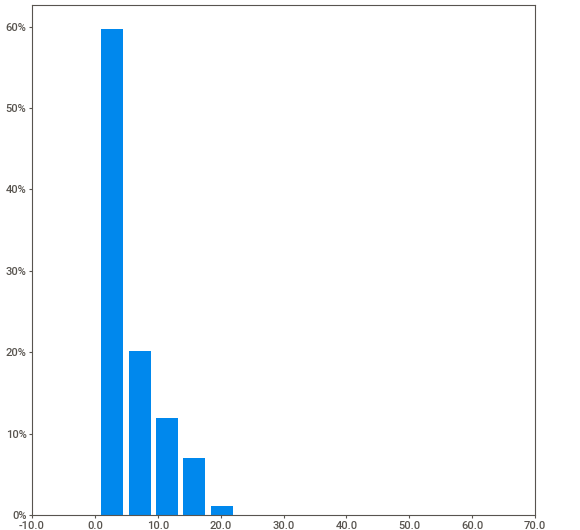
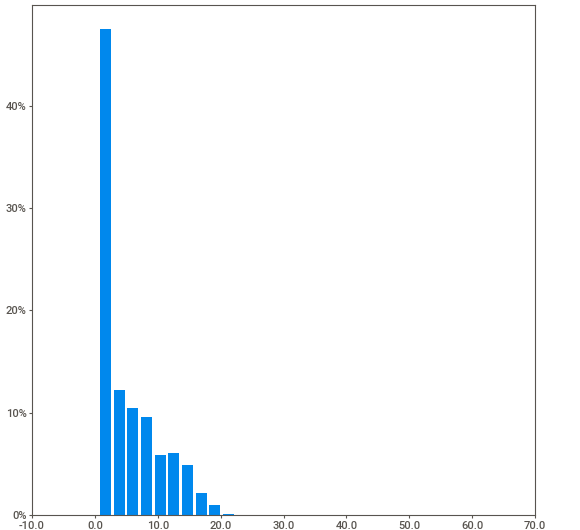
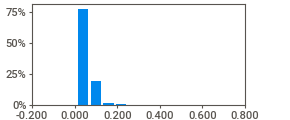
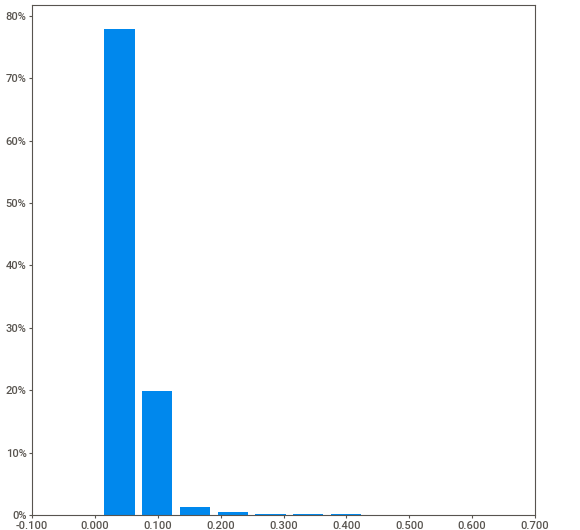
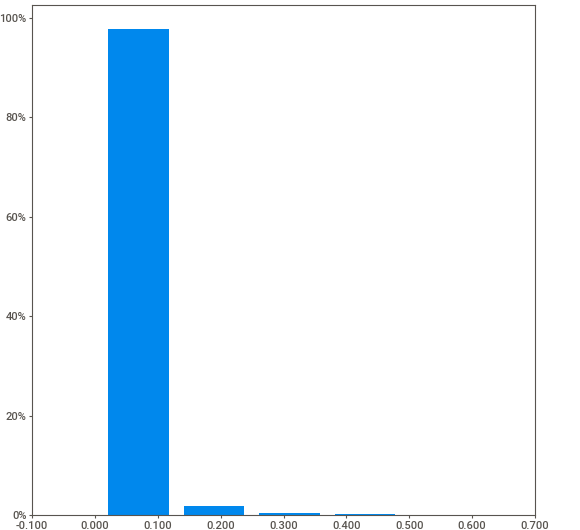
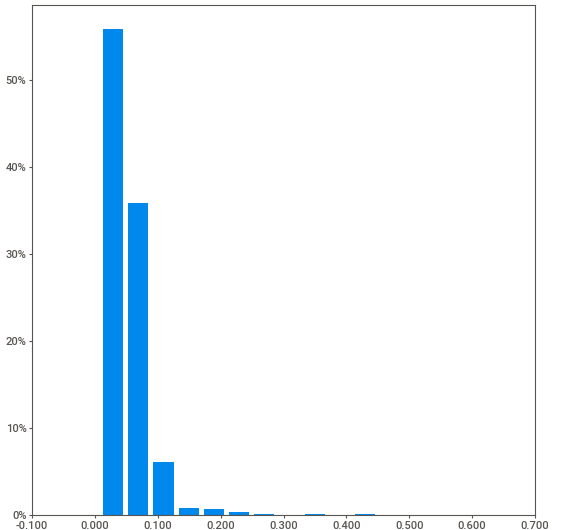
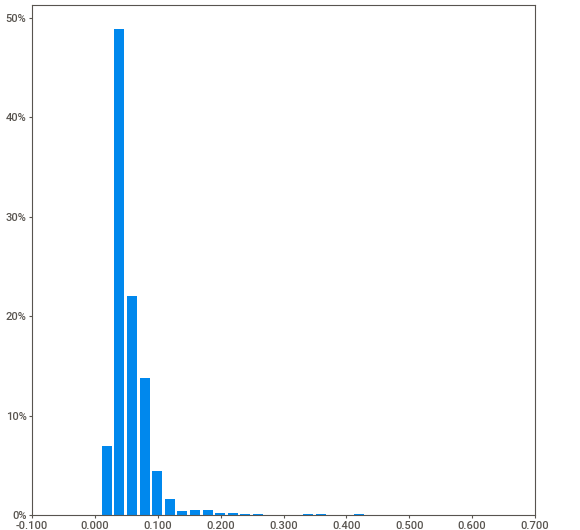
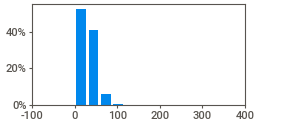
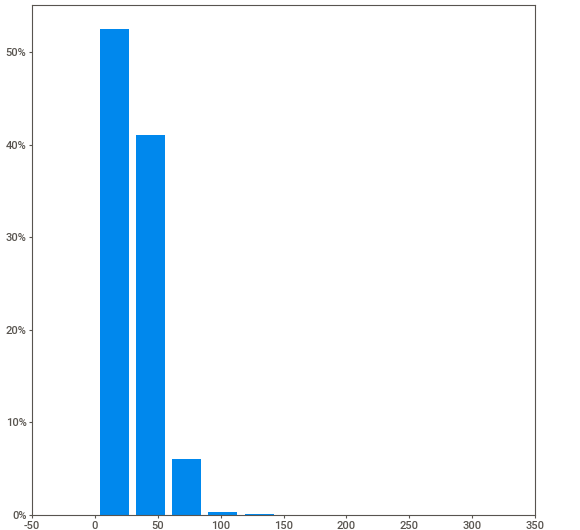
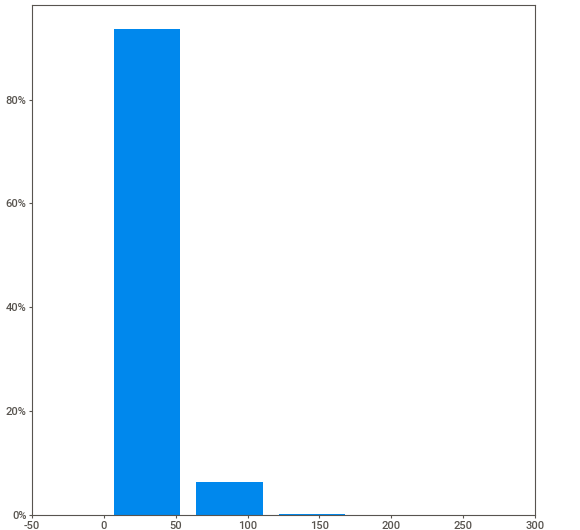
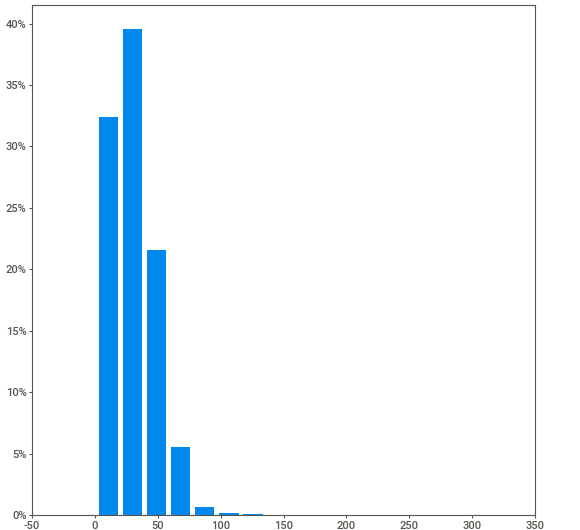
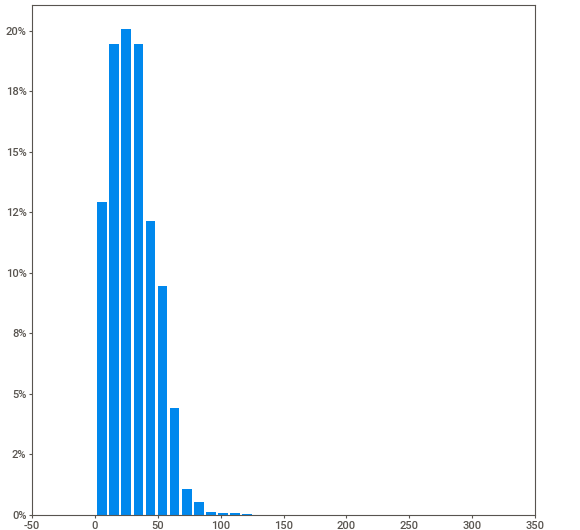
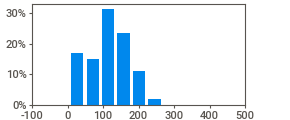
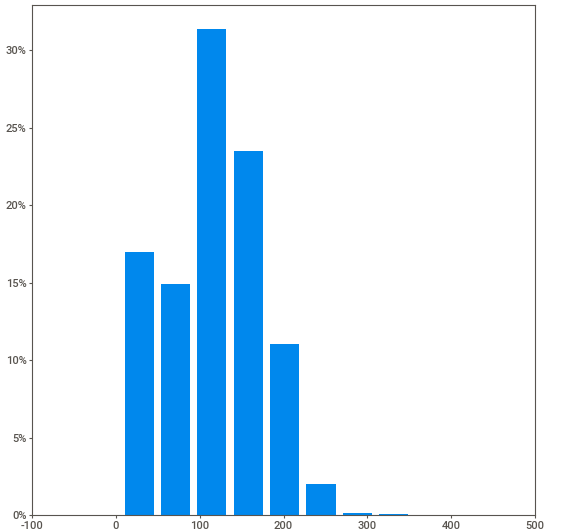
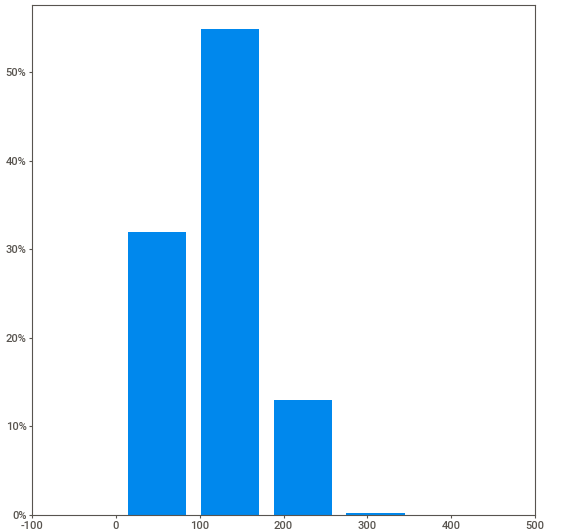
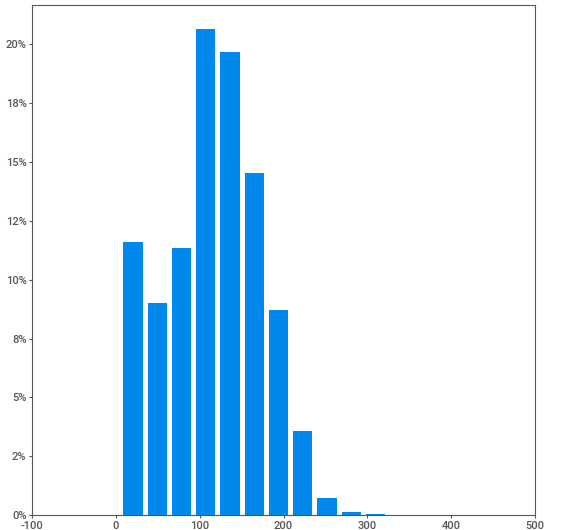
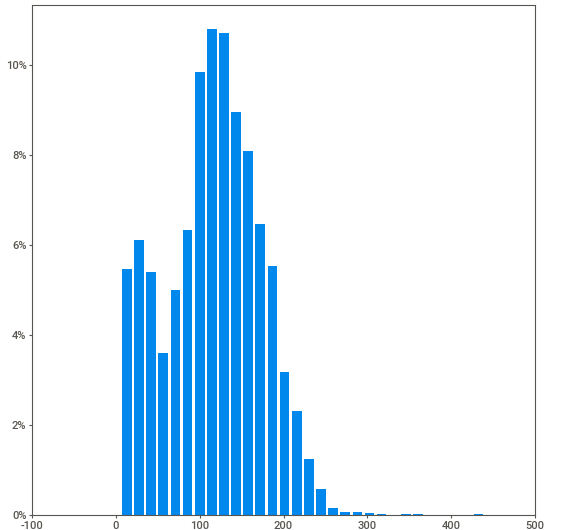
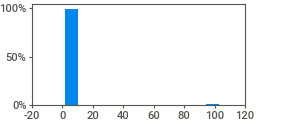
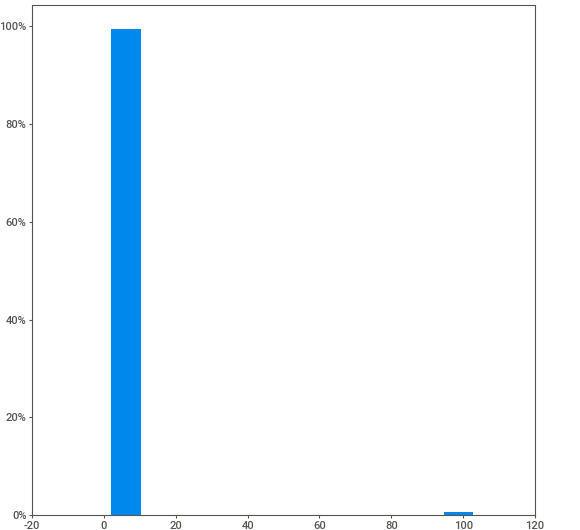
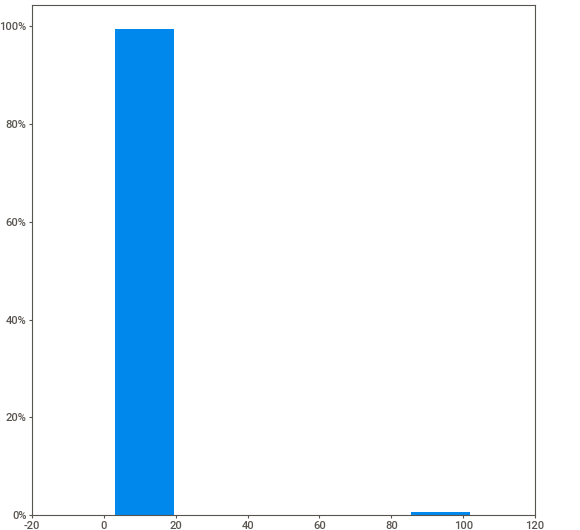
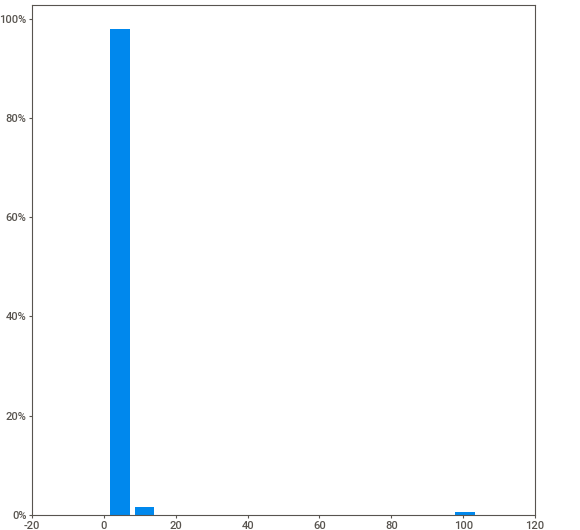
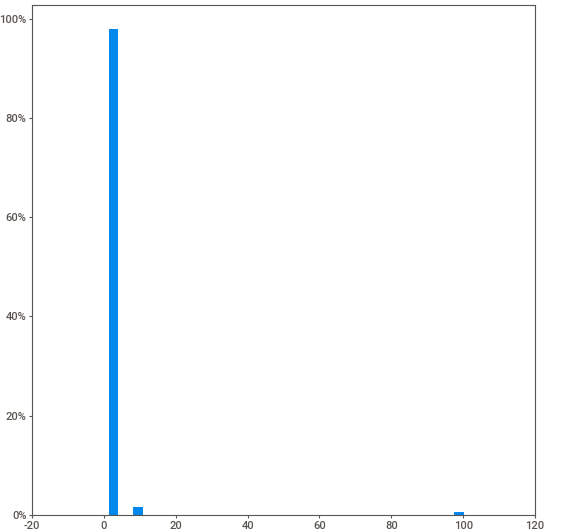
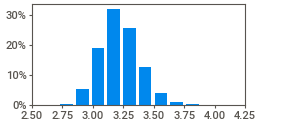
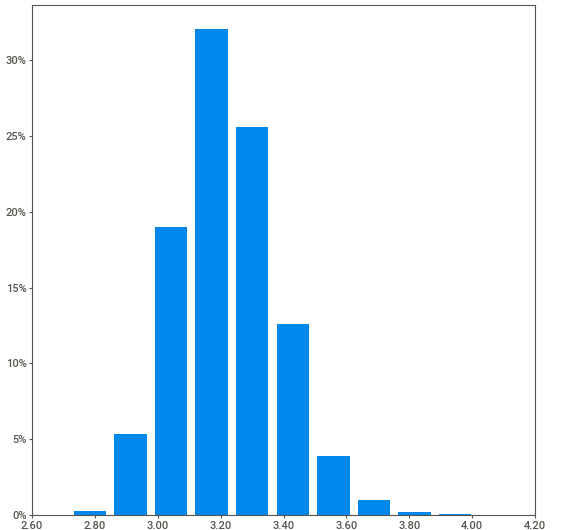
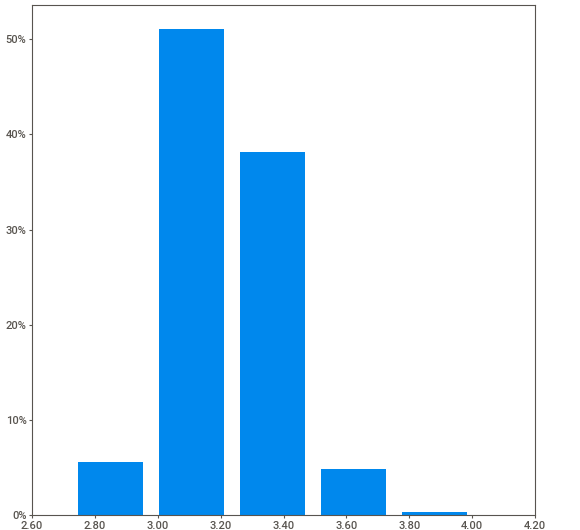
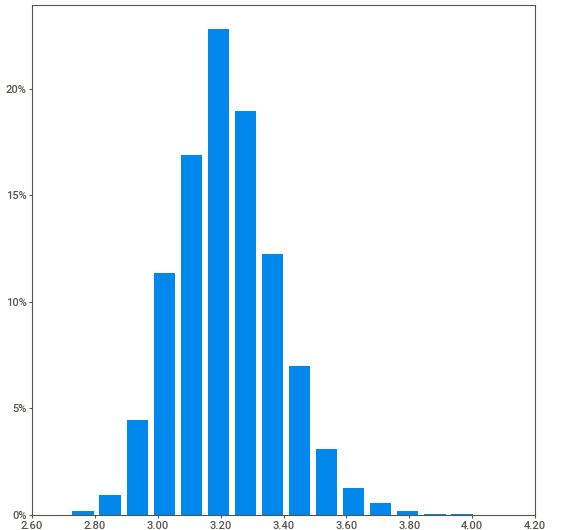
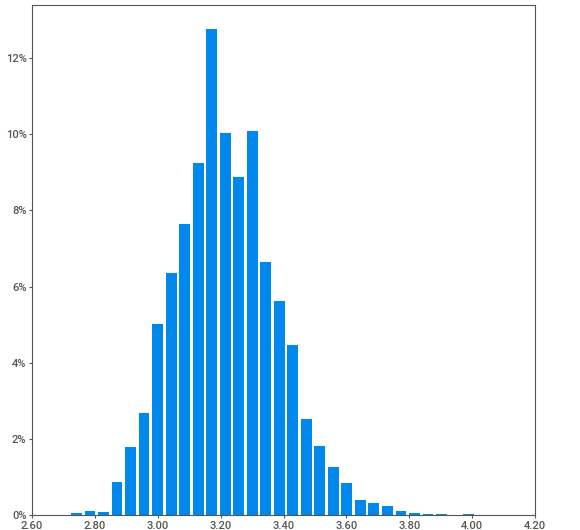
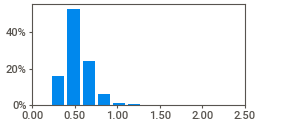
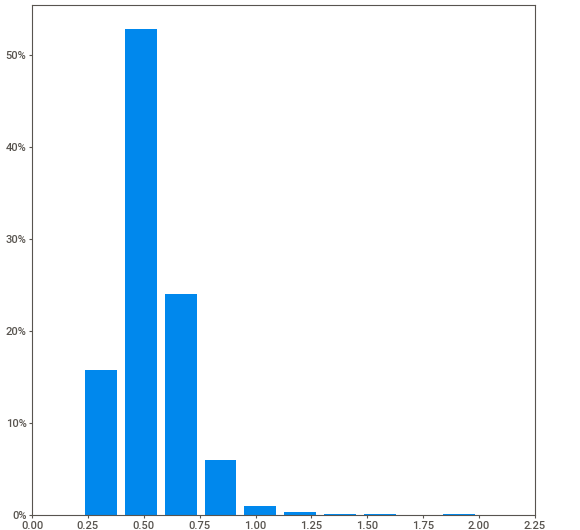
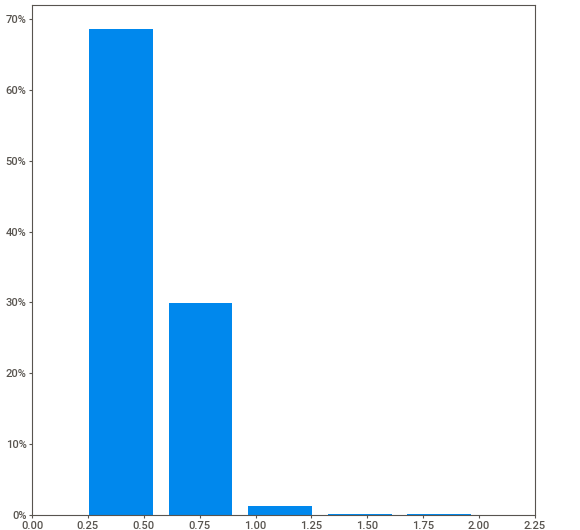
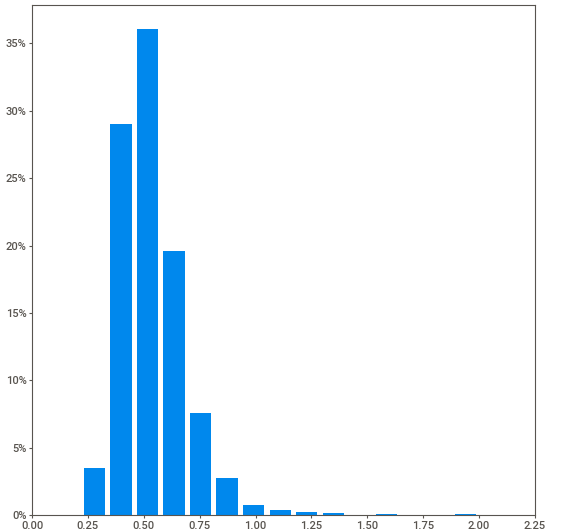
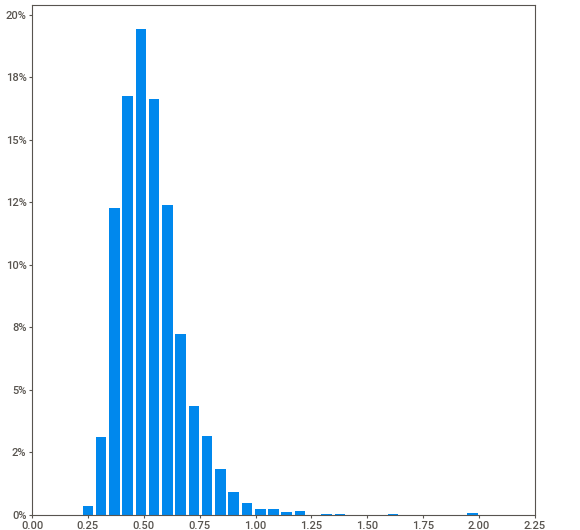
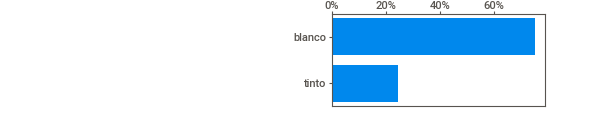
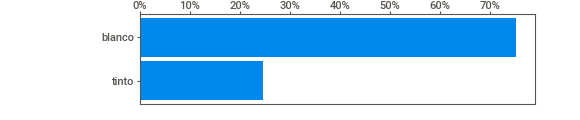
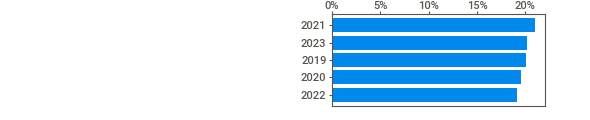
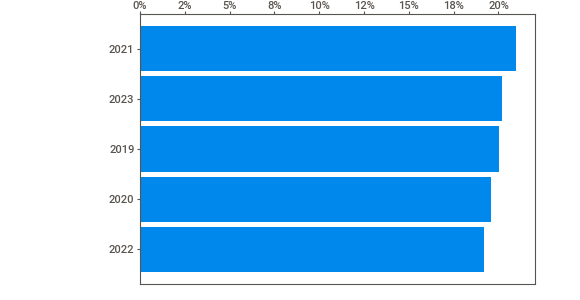
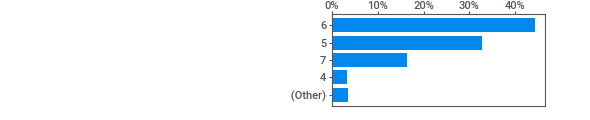
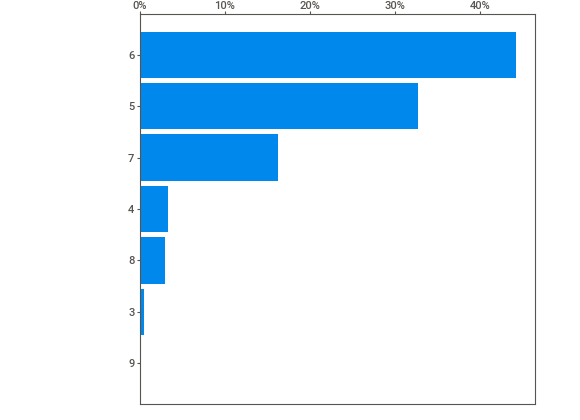
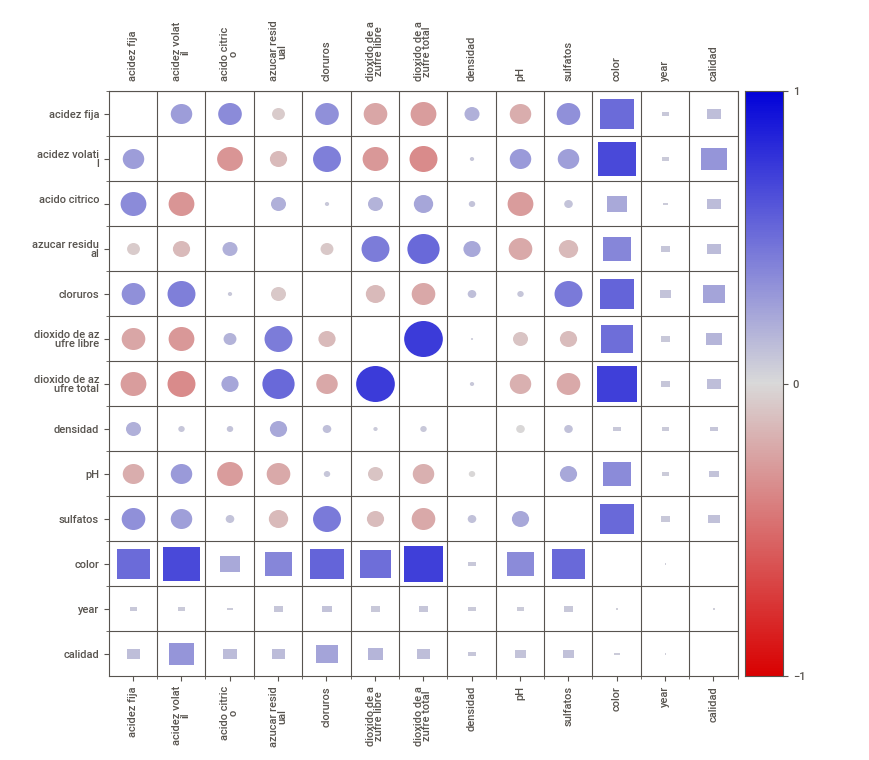
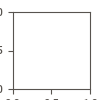

In [ ]:
my_report = sv.analyze(df)
my_report.show_notebook(  w=None,
                h=None,
                scale=None,
                layout='widescreen',
                filepath=None,
                file_layout=None,
                file_scale=None)

# Tipos

In [ ]:
df.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre libre    float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                     object
color                       object
year                         int64
calidad                      int64
dtype: object

- A simple vista se ve por su tipo que hay algún error en la variable **alcohol** ya que sus valores deberían ser de tipo float y no object.
- Una evaluación más detallada refleja que pueden existir en la variable alcohol errores con los decimales

In [ ]:
df['alcohol'].value_counts()

alcohol
9.5                    303
9.4                    272
9.2                    219
10.0                   186
10.5                   182
                      ... 
12.15                    1
131.333.333.333.333      1
117.333.333.333.333      1
11.35                    1
113.666.666.666.667      1
Name: count, Length: 106, dtype: int64

El valor 131.333.333 puede corresponder a un valor de 13.133, el valor 117.333 se puede corresponder con un valor de 11.7 etc.
- Sería lógico pensar que ha podido haber un error a la hora de escribir el valor.

# Información general

In [ ]:
df.describe().T

count         mean        std         min  \
acidez fija              5198.0     7.208580   1.293990     3.90000   
acidez volatil           5198.0     0.339555   0.164113     0.08000   
acido citrico            5198.0     0.318825   0.145903     0.00000   
azucar residual          5198.0     5.432205   4.744450     0.60000   
cloruros                 5198.0     0.055988   0.034539     0.00900   
dioxido de azufre libre  5198.0    30.466718  17.817899     1.00000   
dioxido de azufre total  5198.0   115.570796  56.553849     6.00000   
densidad                 5198.0     1.725172   7.711798     0.98711   
pH                       5198.0     3.218765   0.161618     2.72000   
sulfatos                 5198.0     0.531951   0.149878     0.22000   
year                     5198.0  2020.999038   1.413465  2019.00000   
calidad                  5198.0     5.820316   0.868513     3.00000   

                               25%         50%         75%       max  
acidez fija                 6.4000     7.00000     7.70000    15.900  
acidez volatil              0.2300     0.29000     0.40000     1.580  
acido citrico               0.2500     0.31000     0.39000     1.660  
azucar residual             1.8000     3.00000     8.10000    65.800  
cloruros                    0.0380     0.04700     0.06500     0.610  
dioxido de azufre libre    17.0000    29.00000    41.00000   289.000  
dioxido de azufre total    77.0000   118.00000   155.75000   440.000  
densidad                    0.9924     0.99488     0.99692   103.898  
pH                          3.1100     3.21000     3.32000     4.010  
sulfatos                    0.4300     0.51000     0.60000     2.000  
year                     2020.0000  2021.00000  2022.00000  2023.000  
calidad                     5.0000     6.00000     6.00000     9.000

- No hay valores nulos

- LLama la atención el valor máximo de densidad en 103. Es posible que se haya producido un error similar al dado con la variable alcohol y que la coma haya sido mal puesta.

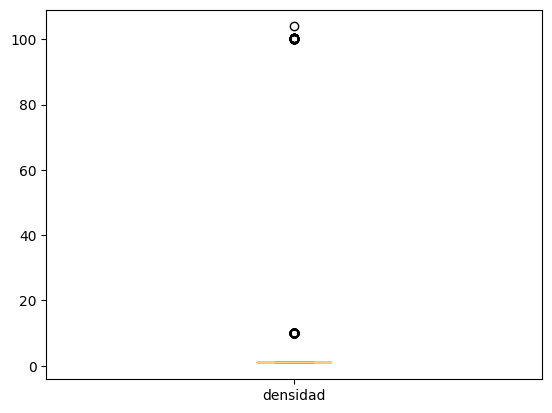

In [ ]:
df.densidad.plot(kind='box');

In [ ]:
df.densidad[df.densidad > 2].value_counts()

densidad
10.002     15
10.001     13
10.004     13
10.006      8
10.003      5
10.008      4
10.014      4
100.014     2
10.026      2
10.015      2
100.044     2
100.038     2
10.103      2
10.017      2
100.242     2
10.022      2
100.015     2
10.021      2
10.005      2
100.013     2
10.011      2
100.315     2
100.037     2
100.369     2
100.012     1
100.016     1
100.289     1
103.898     1
100.098     1
100.051     1
100.196     1
100.182     1
100.025     1
100.118     1
100.055     1
100.295     1
100.005     1
10.024      1
10.032      1
Name: count, dtype: int64

- Asumiremos que los valores de densidad muy superiores a 2 son errores de transcripción de datos y los corregiremos dividiendo entre 10 hasta que el resultado ronde la unidad

# Corrección valores alcohol y densidad

- Utilizaremos las funciones definidas en la sección **Corrección valores feautre** para corregir los valores de alcohol y densidad

In [ ]:
df['alcohol'] = corregir_valores_alcohol(df['alcohol'])

In [ ]:
df['densidad'] = corregir_valores_densidad(df['densidad'])

In [ ]:
df.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre libre    float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                    float64
color                       object
year                         int64
calidad                      int64
dtype: object

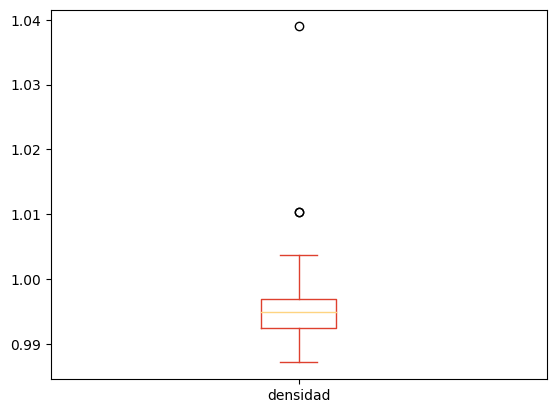

In [ ]:
df.densidad.plot(kind='box');

- Los valores de densidad ya parecen más coherentes

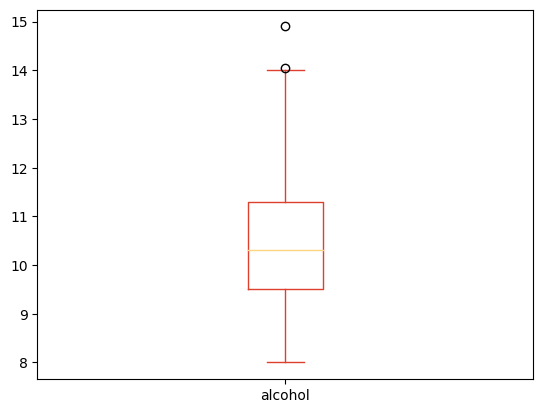

In [ ]:
df.alcohol.plot(kind='box');

- Los valores de alcohol parecen coherentes

# Binarización de variable color

- El siguiente proceso lógico en el tratamiento de los datos es binarizar la variable **color**

In [ ]:
color_map = {'tinto': 1, 'blanco': 0}

df['color'] = df['color'].map(color_map)
df

acidez fija  acidez volatil  acido citrico  azucar residual  \
muestra_id                                                                
0                   9.5            0.56           0.33              2.4   
1                   6.6            0.24           0.28              1.8   
2                   9.4            0.59           0.14              2.0   
3                   6.1            0.32           0.33             10.7   
4                   7.0            0.36           0.35              2.5   
...                 ...             ...            ...              ...   
5193                5.8            0.15           0.49              1.1   
5194                7.1            0.48           0.28              2.8   
5195               12.0            0.37           0.76              4.2   
5196                7.2            0.33           0.22              4.5   
5197                7.4            0.44           0.20             11.5   

            cloruros  dioxido de azufre libre  dioxido de azufre total  \
muestra_id                                                               
0              0.089                     35.0                     67.0   
1              0.028                     39.0                    132.0   
2              0.084                     25.0                     48.0   
3              0.036                     27.0                     98.0   
4              0.048                     67.0                    161.0   
...              ...                      ...                      ...   
5193           0.048                     21.0                     98.0   
5194           0.068                      6.0                     16.0   
5195           0.066                      7.0                     38.0   
5196           0.031                     10.0                     73.0   
5197           0.049                     44.0                    157.0   

            densidad    pH  sulfatos  alcohol  color  year  calidad  
muestra_id                                                           
0            0.99720  3.28      0.73     11.8      1  2021        7  
1            0.99182  3.34      0.46     11.4      0  2021        5  
2            0.99810  3.14      0.56      9.7      1  2019        5  
3            0.99521  3.34      0.52     10.2      0  2021        6  
4            0.99146  3.05      0.56     11.1      0  2023        6  
...              ...   ...       ...      ...    ...   ...      ...  
5193         0.99290  3.19      0.48      9.2      0  2021        5  
5194         0.99682  3.24      0.53     10.3      1  2022        5  
5195         1.00040  3.22      0.60     13.0      1  2022        7  
5196         0.99076  2.97      0.52     12.2      0  2023        7  
5197         0.99800  3.27      0.44      9.0      0  2020        5  

[5198 rows x 14 columns]

# Correlaciones

- Vamos a plotear las correlaciones entre variables para decidir qué estrategias tomar con ciertas variables

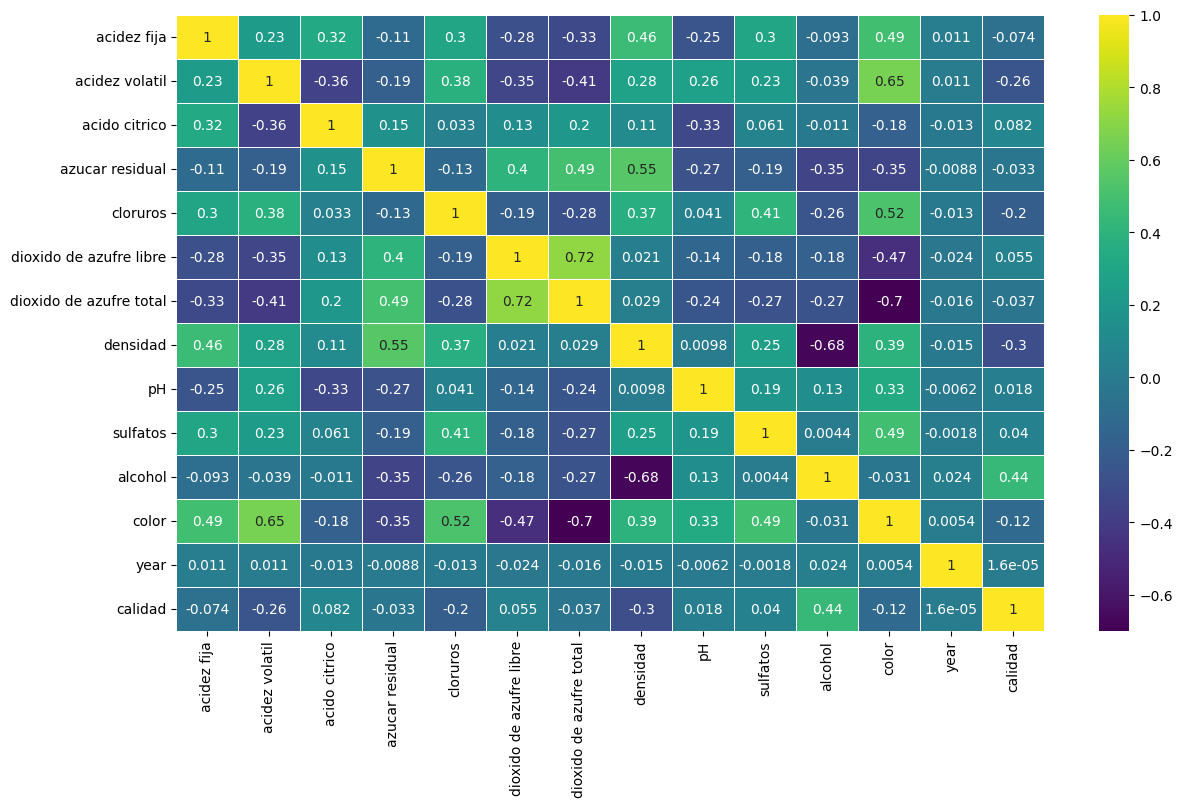

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(numeric_only=True),
            annot=True, linewidth=.5,
            cmap='viridis')
plt.show()

Aspectos interesantes a tener en cuenta
- **color** correlaciona moderadamente con **dioxido de azufre total**, **cloruros**, **acidez volatil** > Posible estrategia crear interacciones de color con el resto de variables
- **alcohol** y **densidad** tienen una correlación negativa > Posible estrategia crear una interacción entre ambas
- la correlación más alta se da entre **dioxido de azufre libre** y **dioxido de azufre total** > Posible estrategia sería sacar el ratio de libre respecto al total

# Mutual Information con variable objetivo

- Utilizaremos la técnica de **Información Mutua** para evaluar la información que aportan las variables a la variable objetivo **calidad**

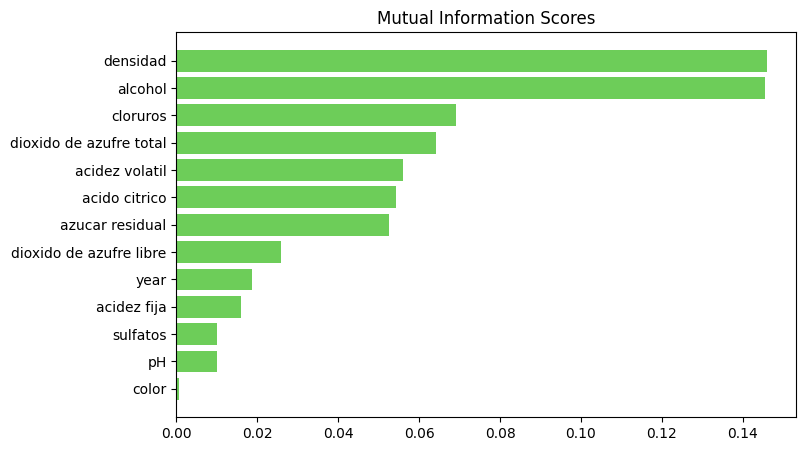

In [ ]:
X = df.copy()
y = X.pop('calidad')

mi_scores = make_mi_scores(X, y)
mi_scores

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plot_mi_scores(mi_scores, ax1)

- Destacan **alcohol** y **densidad** como variables que más información aportan a la variable objetivo

- Vemos que la variable que menos información aporta es **color** según el MI

# Feature importances con RF

- Probamos a evaluar también el parámetro **feature importances** de un RandomForest que da una idea de la importancia de cada variable en la decisión de clasificar la variable objetivo

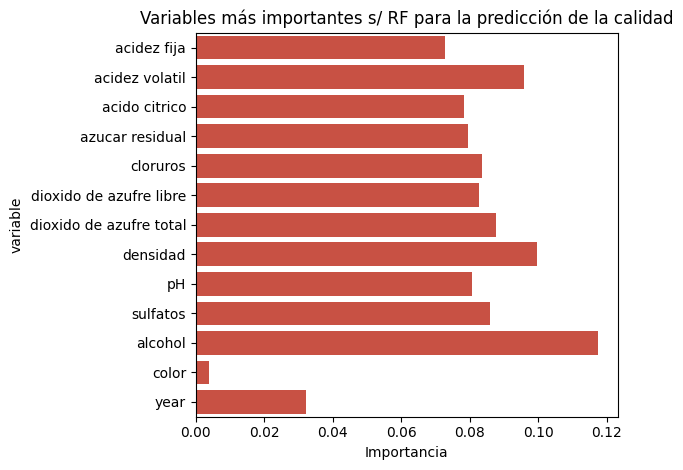

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)
fig, ax = plt.subplots()
ax = sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)
plt.title('Variables más importantes s/ RF para la predicción de la calidad')
plt.xlabel('Importancia')
plt.ylabel('variable')
plt.tight_layout()
plt.show()

- Densidad y alcohol siguen siendo las variables que más información aportan a la varaible calidad
- color es la variable que menos información aporta

# Creación interacciones entre variables - Feature Engineering

- Vamos a intentar aumentar la información que aporta la variable **color** que ya vemos que es muy poca. En el gráfico de correlaciones se observa que el color correlaciona notablemente con acidez volátil, dioxido de azufre total y cloruros. Una estrategia posible es crear interacciones entre dichas variables
- Crearemos nuevas variables de interacción multiplicando cada variable

Creamos un nuevo df_fe para realizar las modificaciones

In [ ]:
df_fe = df.copy()

In [ ]:
df_fe['color_acidez_vol'] = df_fe['color'] * df_fe['acidez volatil']
df_fe['color_dioxido_azufre'] = df_fe['color'] * df_fe['dioxido de azufre total']
df_fe['color_cloruros'] = df_fe['color'] * df_fe['cloruros']

- Las variables **alcohol** y **densidad** ambas correlacionan entre ellas y son las variables que más información aportan en relación a la calidad del vino. Vamos a crear una nueva variable que recoja la información de ambas mediante la multiplicación

In [ ]:
df_fe['densidad_alcohol'] = df_fe['densidad'] * df_fe['alcohol']

- El **dioxido de azufre libre** correlaciona con el total fuertemente, como es lógico. Para evitar problemas de multicolinealidad vamos a crear una nueva variable que describa la relación entre el dioxido de azufre libre y el total. Eliminaremos el dioxido de azufre libre

In [ ]:
df_fe['SO2_l / SO2_tot'] = df_fe['dioxido de azufre libre'] / df_fe['dioxido de azufre total']
df_fe.drop(columns=['dioxido de azufre libre'], inplace=True)

In [ ]:
df_fe

acidez fija  acidez volatil  acido citrico  azucar residual  \
muestra_id                                                                
0                   9.5            0.56           0.33              2.4   
1                   6.6            0.24           0.28              1.8   
2                   9.4            0.59           0.14              2.0   
3                   6.1            0.32           0.33             10.7   
4                   7.0            0.36           0.35              2.5   
...                 ...             ...            ...              ...   
5193                5.8            0.15           0.49              1.1   
5194                7.1            0.48           0.28              2.8   
5195               12.0            0.37           0.76              4.2   
5196                7.2            0.33           0.22              4.5   
5197                7.4            0.44           0.20             11.5   

            cloruros  dioxido de azufre total  densidad    pH  sulfatos  \
muestra_id                                                                
0              0.089                     67.0   0.99720  3.28      0.73   
1              0.028                    132.0   0.99182  3.34      0.46   
2              0.084                     48.0   0.99810  3.14      0.56   
3              0.036                     98.0   0.99521  3.34      0.52   
4              0.048                    161.0   0.99146  3.05      0.56   
...              ...                      ...       ...   ...       ...   
5193           0.048                     98.0   0.99290  3.19      0.48   
5194           0.068                     16.0   0.99682  3.24      0.53   
5195           0.066                     38.0   1.00040  3.22      0.60   
5196           0.031                     73.0   0.99076  2.97      0.52   
5197           0.049                    157.0   0.99800  3.27      0.44   

            alcohol  color  year  calidad  color_acidez_vol  \
muestra_id                                                    
0              11.8      1  2021        7              0.56   
1              11.4      0  2021        5              0.00   
2               9.7      1  2019        5              0.59   
3              10.2      0  2021        6              0.00   
4              11.1      0  2023        6              0.00   
...             ...    ...   ...      ...               ...   
5193            9.2      0  2021        5              0.00   
5194           10.3      1  2022        5              0.48   
5195           13.0      1  2022        7              0.37   
5196           12.2      0  2023        7              0.00   
5197            9.0      0  2020        5              0.00   

            color_dioxido_azufre  color_cloruros  densidad_alcohol  \
muestra_id                                                           
0                           67.0           0.089         11.766960   
1                            0.0           0.000         11.306748   
2                           48.0           0.084          9.681570   
3                            0.0           0.000         10.151142   
4                            0.0           0.000         11.005206   
...                          ...             ...               ...   
5193                         0.0           0.000          9.134680   
5194                        16.0           0.068         10.267246   
5195                        38.0           0.066         13.005200   
5196                         0.0           0.000         12.087272   
5197                         0.0           0.000          8.982000   

            SO2_l / SO2_tot  
muestra_id                   
0                  0.522388  
1                  0.295455  
2                  0.520833  
3                  0.275510  
4                  0.416149  
...                     ...  
5193               0.214286  
5194               0.375000  
5195               0.184211  

## Mutual Information con nuevo dataset de interacciones

- Vamos a comprobar la información mutua con respecto a la variable objetivo de este nuevo dataset con las nuevas variables incorporadas

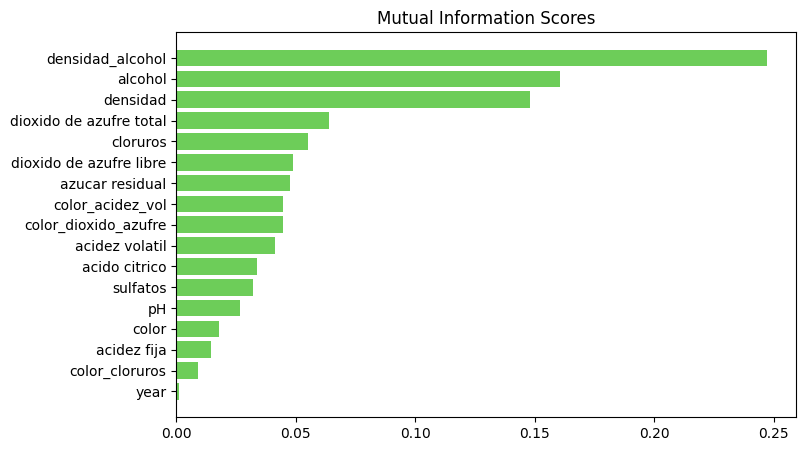

In [ ]:
X = df_fe.copy()
y = X.pop('calidad')

mi_scores = make_mi_scores(X, y)
mi_scores

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plot_mi_scores(mi_scores, ax1)

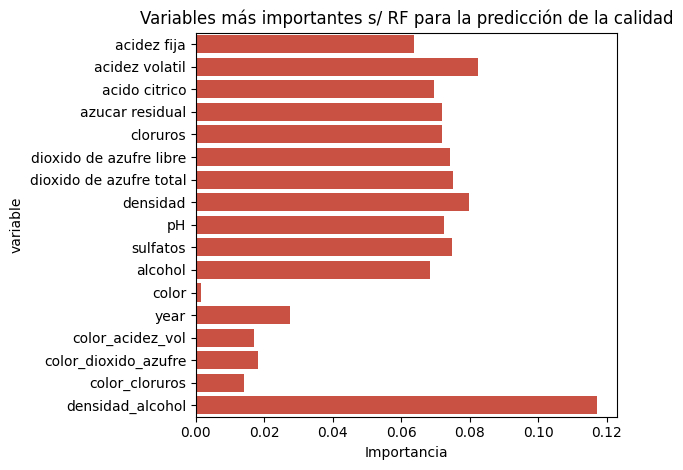

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)
fig, ax = plt.subplots()
ax = sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)
plt.title('Variables más importantes s/ RF para la predicción de la calidad')
plt.xlabel('Importancia')
plt.ylabel('variable')
plt.tight_layout()
plt.show()

- Algunas de las interacciones que hemos añadido aportan sustancialmente más información que muchas de las variables originales. Nótese el caso de **densidad_alcohol** y el ratio **SO2 libre / SO2 total** que lideran la tabla

# Distribuciones

- Vamos a explorar cómo se distribuyen las variables en el dataset con las nuevas variables añadidas

In [ ]:
df_fe.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                    float64
color                        int64
year                         int64
calidad                      int64
color_acidez_vol           float64
color_dioxido_azufre       float64
color_cloruros             float64
densidad_alcohol           float64
SO2_l / SO2_tot            float64
dtype: object

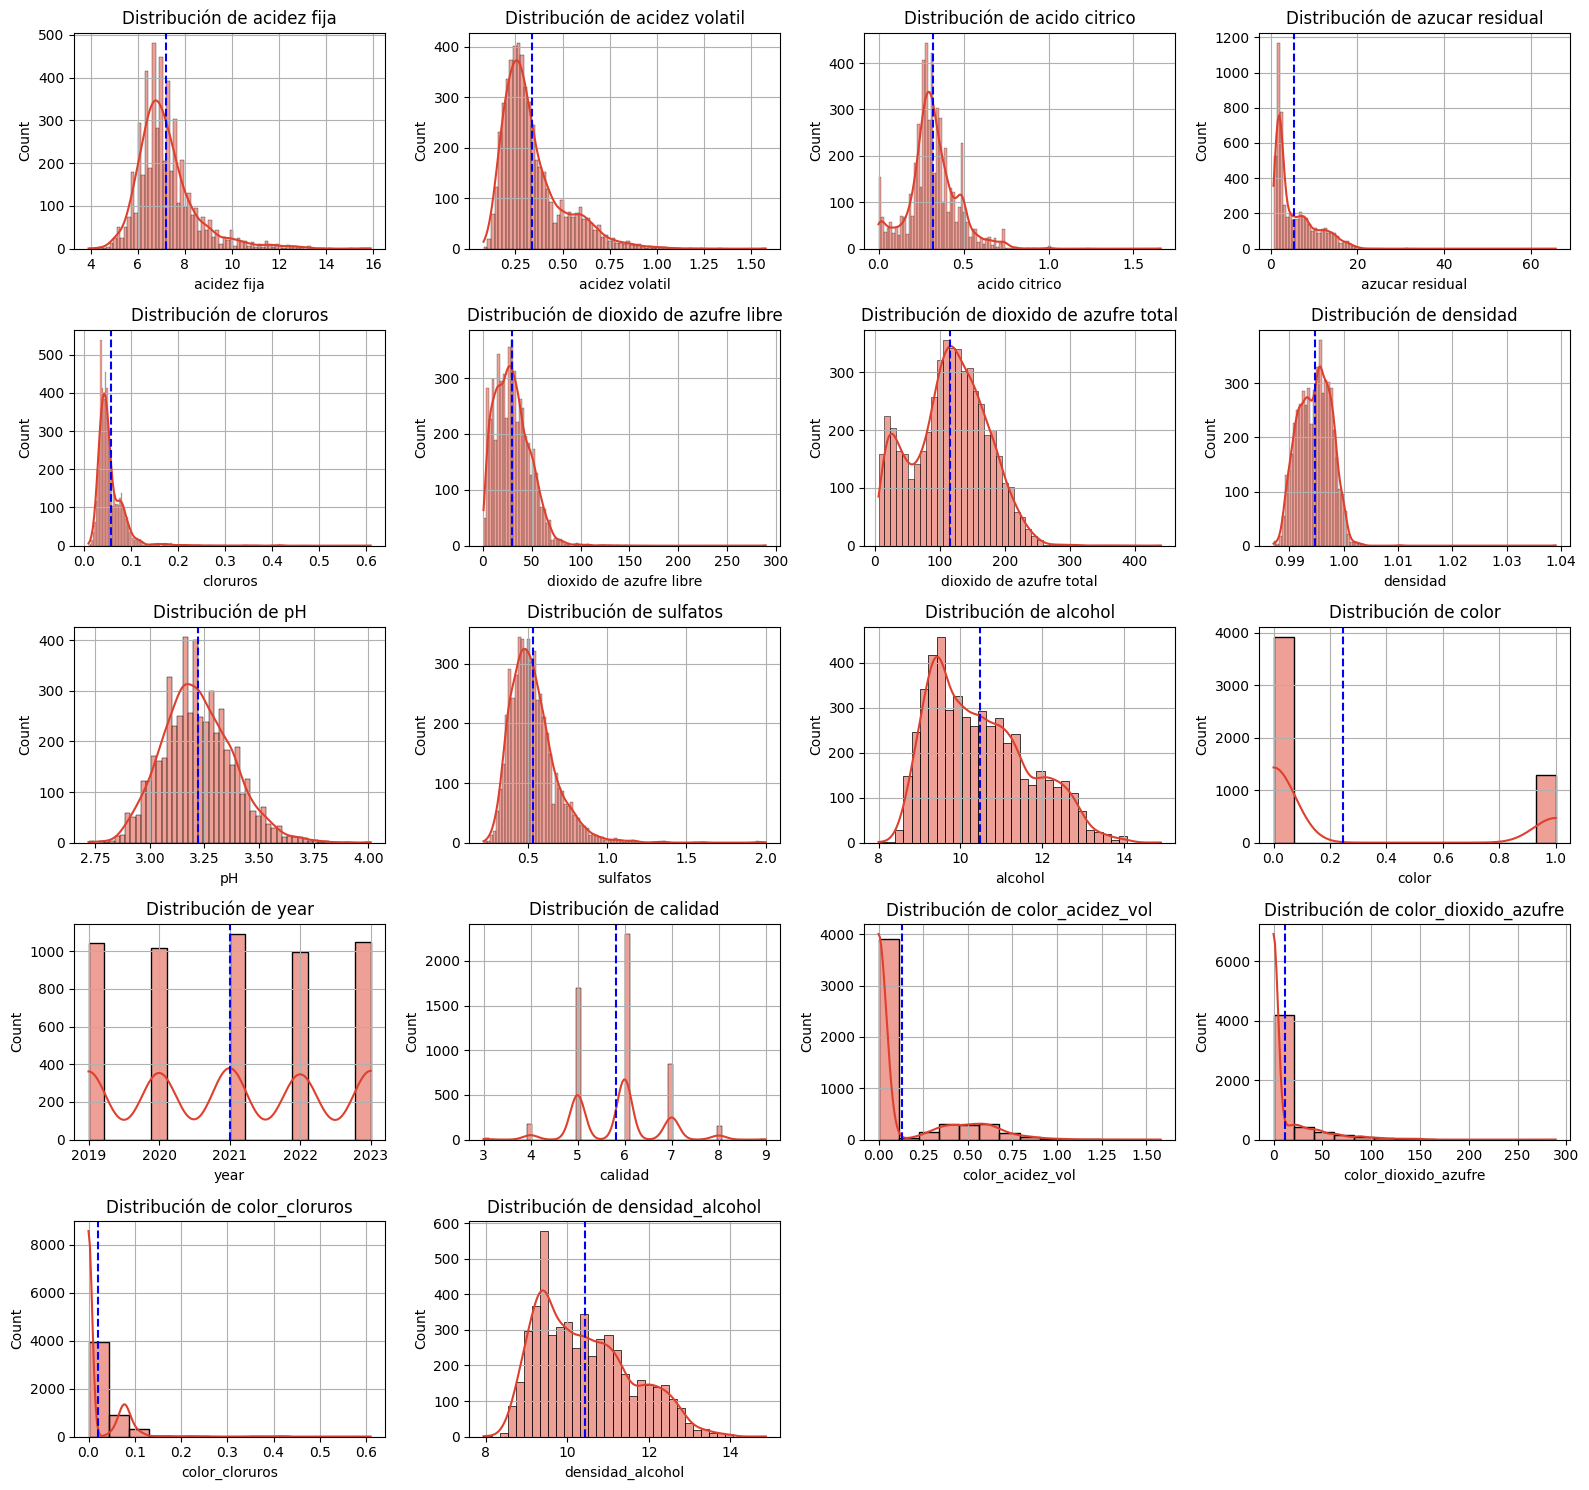

In [ ]:
plotear_distribucion_variables(df_fe)

# Aplicar más transformaciones

- A la vista de las distribuciones de los valores de las variables aplicaremos algunas transformaciones para homogeneizar las distribuciones y adaptarlas a una distribución normal

- Por ejemplo la variable **dioxido de azufre total** tiene dos modos claros. Podríamos probar una estrategia de distancias gausianas a cada modo
- Algunas distribuciones como la de **azucar residual** están sesgadas y podrían beneficiarse de una conversión logarítmica

## RBF similitud

La distribución de la variable **Dioxido de azufre total** tiene dos claros modos:
- uno en 27
- Otro en su media de 126

Computando la distancia Gausiana podemos crear dos nuevas variables que representen la distancia a cada modo

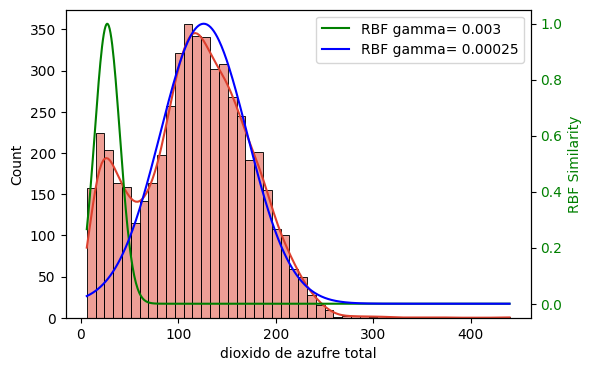

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df_fe['dioxido de azufre total'], kde=True, label='kde')

axis_diox = np.linspace(df_fe[['dioxido de azufre total']].min(),
                   df_fe[['dioxido de azufre total']].max(),
                   500).reshape(-1, 1)

gamma_1 = 0.003
gamma_2 = 2.5e-4
rbf_diox_1 = rbf_kernel(axis_diox, [[27]], gamma=gamma_1)
rbf_diox_2 = rbf_kernel(axis_diox, [[126]], gamma=gamma_2)

ax2 = ax.twinx()
ax2.set_ylabel("RBF Similarity", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax2.plot(axis_diox, rbf_diox_1, label=f'RBF gamma= {gamma_1}', color='green')
ax2.plot(axis_diox, rbf_diox_2, label=f'RBF gamma= {gamma_2}', color='blue')
plt.legend()
plt.show()

- Creamos dos nuevas variables que representen la distancia a cada nodo de cada muestra

In [ ]:
df_simil = df_fe.copy()

sf_coords = 27, 126
rbf_transformer_1 = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[27]], gamma=gamma_1))
rbf_transformer_2 = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[126]], gamma=gamma_2))

diox_simil_1 = rbf_transformer_1.transform(df_simil[["dioxido de azufre total"]])
diox_simil_2 = rbf_transformer_2.transform(df_simil[["dioxido de azufre total"]])


df_simil['diox_simil_1'] = diox_simil_1
df_simil['diox_simil_2'] = diox_simil_2

In [ ]:
df_simil.head()

acidez fija  acidez volatil  acido citrico  azucar residual  \
muestra_id                                                                
0                   9.5            0.56           0.33              2.4   
1                   6.6            0.24           0.28              1.8   
2                   9.4            0.59           0.14              2.0   
3                   6.1            0.32           0.33             10.7   
4                   7.0            0.36           0.35              2.5   

            cloruros  dioxido de azufre libre  dioxido de azufre total  \
muestra_id                                                               
0              0.089                     35.0                     67.0   
1              0.028                     39.0                    132.0   
2              0.084                     25.0                     48.0   
3              0.036                     27.0                     98.0   
4              0.048                     67.0                    161.0   

            densidad    pH  sulfatos  alcohol  color  year  calidad  \
muestra_id                                                            
0            0.99720  3.28      0.73     11.8      1  2021        7   
1            0.99182  3.34      0.46     11.4      0  2021        5   
2            0.99810  3.14      0.56      9.7      1  2019        5   
3            0.99521  3.34      0.52     10.2      0  2021        6   
4            0.99146  3.05      0.56     11.1      0  2023        6   

            color_acidez_vol  color_dioxido_azufre  color_cloruros  \
muestra_id                                                           
0                       0.56                  67.0           0.089   
1                       0.00                   0.0           0.000   
2                       0.59                  48.0           0.084   
3                       0.00                   0.0           0.000   
4                       0.00                   0.0           0.000   

            densidad_alcohol  diox_simil_1  diox_simil_2  
muestra_id                                                
0                  11.766960  8.229747e-03      0.418847  
1                  11.306748  4.322251e-15      0.991040  
2                   9.681570  2.663351e-01      0.218493  
3                  10.151142  2.704983e-07      0.822012  
4                  11.005206  4.031112e-24      0.736203

Evaluamos la información mutua que aportan estas nuevas variables

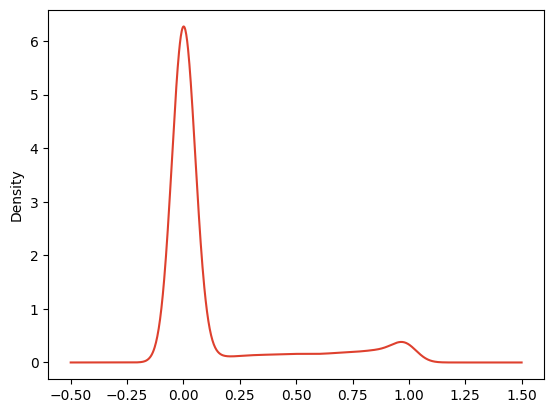

In [ ]:
df_simil['diox_simil_1'].plot(kind='kde');

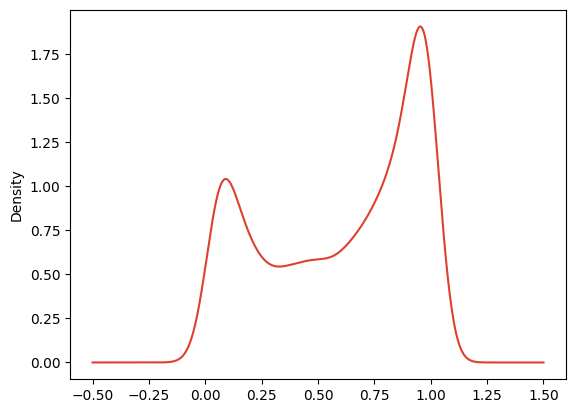

In [ ]:
df_simil['diox_simil_2'].plot(kind='kde');

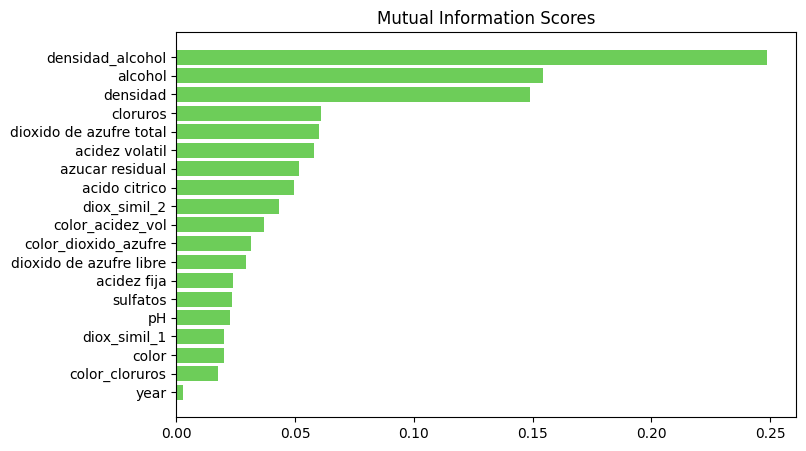

In [ ]:
X = df_simil.copy()
y = X.pop('calidad')

mi_scores = make_mi_scores(X, y)
mi_scores

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plot_mi_scores(mi_scores, ax1)

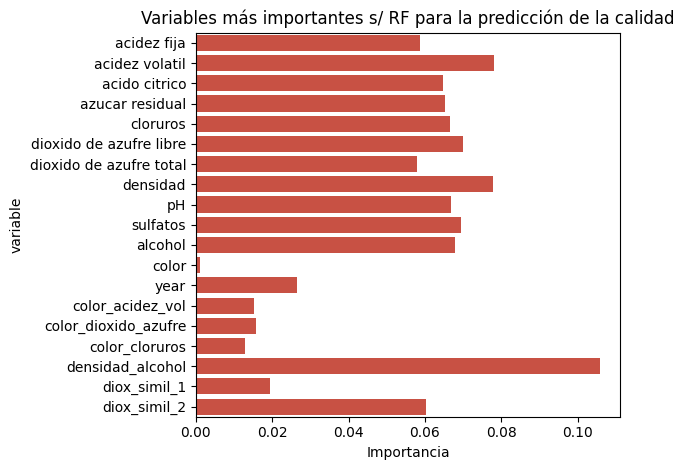

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)
fig, ax = plt.subplots()
ax = sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)
plt.title('Variables más importantes s/ RF para la predicción de la calidad')
plt.xlabel('Importancia')
plt.ylabel('variable')
plt.tight_layout()
plt.show()

- Apreciamos que las nuevas variables **diox_simil_1** y **diox_simil_2** aportan algo de información pero no son las que más aportan, ni mucho menos.
-  **Diox_simil_2** aporta bastante más información según las feature importances del modelo RF que en la MI comparativamente con las demás.

## Kmeans

- Vamos a probar a hacer una transformación similar pero usando KMeans y variables categóricas
- La estrategia es similar a la distancia Gausiana anterior, sin embargo en este caso usaremos Kmeans para determinar el número de clusters en la variable **dioxido de azufre total** y posteriormente categorizar cada muestra en su determinado cluster con la esperanza de que esta nueva variable aporte información para predecir la calidad del vino.

- Primero hallaremos el número de clusters ideal

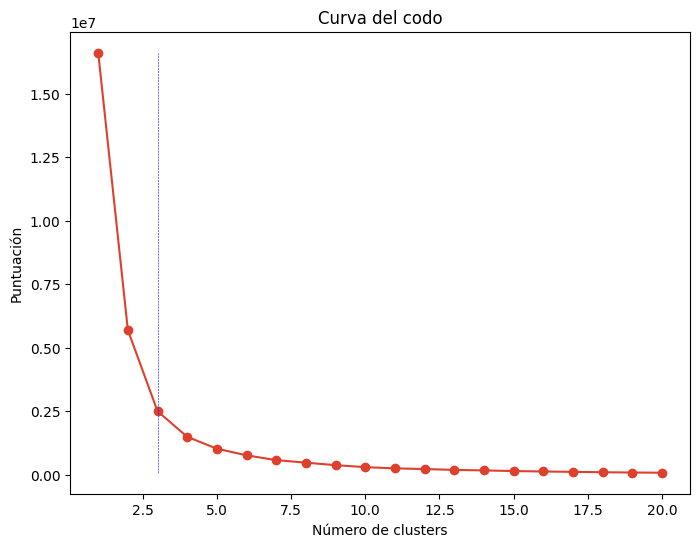

In [ ]:
num_clusters = range(1, 21)

kmeans = [
    KMeans(n_clusters=i, random_state=42, n_init='auto')
    for i in num_clusters
    ]

score = [
    kmeans[i].fit(
        df_fe[['dioxido de azufre total']]
        ).inertia_ for i in range(len(kmeans))
        ]

plt.figure(figsize=(8,6))
plt.plot(num_clusters, score, 'o-')
plt.vlines(x=3, ymin=min(score), ymax=max(score), color='b', linestyle='--',
           linewidth=0.4)
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.title('Curva del codo')
plt.show()

El número óptimo de clusters para la variable es de 3.

In [ ]:
clusterizer = KMeans(n_clusters=3, n_init='auto', random_state=42)

c = clusterizer.fit(df[['dioxido de azufre total']])

In [ ]:
c.cluster_centers_

array([[115.94078118],
       [ 40.40150376],
       [182.21116342]])

Añadimos la nueva variable categórica con 3 valores distintos en función del cluster al que pertenezcan: 0, 2 o 3.

In [ ]:
df_km = df_fe.copy()

df_km['diox_mode'] = c.labels_

One hoteamos la nueva variable

In [ ]:
oh_encoder = OneHotEncoder()
sparse_array = oh_encoder.fit_transform(df_km[['diox_mode']])

diox_modes_df = pd.DataFrame(
    sparse_array.toarray(),
    columns=['diox_modo_1', 'diox_modo_2', 'diox_modo3'],
    dtype='int64'
)

df_km = pd.concat([df_km, diox_modes_df], axis=1).drop(columns=['diox_mode'])

In [ ]:
df_km

acidez fija  acidez volatil  acido citrico  azucar residual  cloruros  \
0             9.5            0.56           0.33              2.4     0.089   
1             6.6            0.24           0.28              1.8     0.028   
2             9.4            0.59           0.14              2.0     0.084   
3             6.1            0.32           0.33             10.7     0.036   
4             7.0            0.36           0.35              2.5     0.048   
...           ...             ...            ...              ...       ...   
5193          5.8            0.15           0.49              1.1     0.048   
5194          7.1            0.48           0.28              2.8     0.068   
5195         12.0            0.37           0.76              4.2     0.066   
5196          7.2            0.33           0.22              4.5     0.031   
5197          7.4            0.44           0.20             11.5     0.049   

      dioxido de azufre total  densidad    pH  sulfatos  alcohol  ...  year  \
0                        67.0   0.99720  3.28      0.73     11.8  ...  2021   
1                       132.0   0.99182  3.34      0.46     11.4  ...  2021   
2                        48.0   0.99810  3.14      0.56      9.7  ...  2019   
3                        98.0   0.99521  3.34      0.52     10.2  ...  2021   
4                       161.0   0.99146  3.05      0.56     11.1  ...  2023   
...                       ...       ...   ...       ...      ...  ...   ...   
5193                     98.0   0.99290  3.19      0.48      9.2  ...  2021   
5194                     16.0   0.99682  3.24      0.53     10.3  ...  2022   
5195                     38.0   1.00040  3.22      0.60     13.0  ...  2022   
5196                     73.0   0.99076  2.97      0.52     12.2  ...  2023   
5197                    157.0   0.99800  3.27      0.44      9.0  ...  2020   

      calidad  color_acidez_vol  color_dioxido_azufre  color_cloruros  \
0           7              0.56                  67.0           0.089   
1           5              0.00                   0.0           0.000   
2           5              0.59                  48.0           0.084   
3           6              0.00                   0.0           0.000   
4           6              0.00                   0.0           0.000   
...       ...               ...                   ...             ...   
5193        5              0.00                   0.0           0.000   
5194        5              0.48                  16.0           0.068   
5195        7              0.37                  38.0           0.066   
5196        7              0.00                   0.0           0.000   
5197        5              0.00                   0.0           0.000   

      densidad_alcohol  SO2_l / SO2_tot  diox_modo_1  diox_modo_2  diox_modo3  
0            11.766960         0.522388            0            1           0  
1            11.306748         0.295455            1            0           0  
2             9.681570         0.520833            0            1           0  
3            10.151142         0.275510            1            0           0  
4            11.005206         0.416149            0            0           1  
...                ...              ...          ...          ...         ...  
5193          9.134680         0.214286            1            0           0  
5194         10.267246         0.375000            0            1           0  
5195         13.005200         0.184211            0            1           0  
5196         12.087272         0.136986            0            1           0  
5197          8.982000         0.280255            0            0           1  

[5198 rows x 21 columns]

Evaluamos los MI y feature importances para comprobar la relevancia de estas nuevas variables creadas

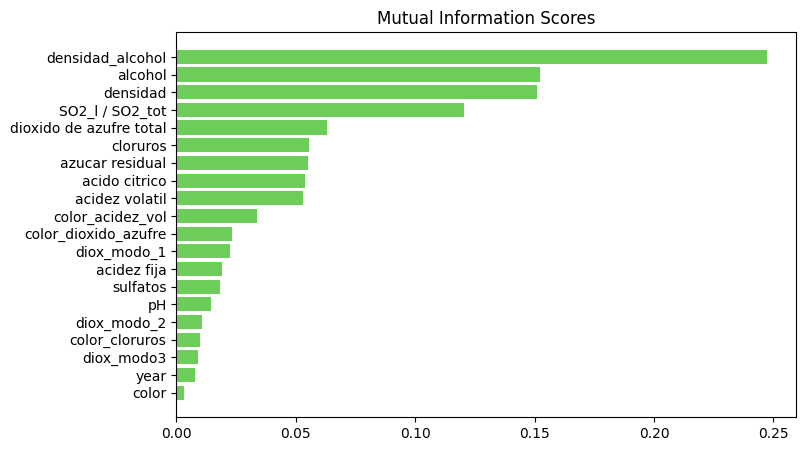

In [ ]:
X = df_km.copy()
y = X.pop('calidad')

mi_scores = make_mi_scores(X, y)
mi_scores

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
plot_mi_scores(mi_scores, ax1)

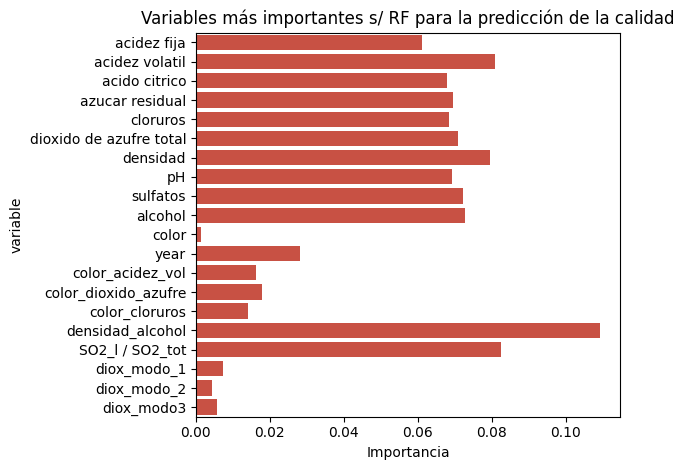

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)
fig, ax = plt.subplots()
ax = sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)
plt.title('Variables más importantes s/ RF para la predicción de la calidad')
plt.xlabel('Importancia')
plt.ylabel('variable')
plt.tight_layout()
plt.show()

En general, el método de clusterización parece que aporta menos información que computar la distancia Gausiana mediante RBF, **por lo tanto nos quedaremos con el primer método.**

# Balancear - resamplear

- Vamos a probar técnicas de remuestreo del dataset. Utilizaremos la librería **[imblearn](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)**

- Una técnica de remuestro conocida es el **SMOTE** Synthetic Minority Over-sampling Technique

In [ ]:
df_simil['calidad'].value_counts().sort_index()

calidad
3      22
4     170
5    1699
6    2301
7     846
8     155
9       5
Name: count, dtype: int64

In [ ]:
# La clase menos representada de nuestro dataset
# tiene solo 5 muestras
smote = SMOTE(random_state=42,
                k_neighbors=4)

# Partimos del dataset df_simil
X = df_simil.drop(columns=['calidad'])
y = df_simil['calidad']

X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
y_smote.value_counts().sort_index()

calidad
3    2301
4    2301
5    2301
6    2301
7    2301
8    2301
9    2301
Name: count, dtype: int64

Este método ha igualado la cantidad de muestras a las de la clase más representativa

- Otro método de remuestreo es el **ADASYN**

In [ ]:
ada = ADASYN(random_state=42,
             n_neighbors=4)

# Partimos del dataset df_simil
X = df_simil.drop(columns=['calidad'])
y = df_simil['calidad']

X_ada, y_ada = ada.fit_resample(X, y)

In [ ]:
y_ada.value_counts().sort_index()

calidad
3    2309
4    2344
5    2347
6    2301
7    2386
8    2239
9    2300
Name: count, dtype: int64

- Este método ha oversampleado las clases minoritarias pero no iguala el número de muestras de todas las clases

- Otra posible estrategia para el remuestreo es combinar oversampling y undersampling con métodos como el **SMOTEENN**

In [ ]:
sme = SMOTEENN(random_state=42,
               smote=smote) # Usamos el objeto SMOTE definido anteriormente

# Partimos del dataset df_simil
X = df_simil.drop(columns=['calidad'])
y = df_simil['calidad']

X_sme, y_sme = sme.fit_resample(X, y)

In [ ]:
y_sme.value_counts().sort_index()

calidad
3    2022
4    1945
5     758
6     252
7    1469
8    2101
9    2300
Name: count, dtype: int64

- En este caso vemos que el algortimo ha hecho las clases más representativas que pasen a ser las menos representativas y viceversa

- Podríamos combinar varias clasificadores entrenados sobre datasets remuestreados de maneras distintas y comprobar sus rendimientos

In [ ]:
cw = dict(enumerate(

    (len(y) / (len(np.bincount(y))) / i) for i in np.bincount(y)
)
    )
cw

{0: 33.75324675324675,
 1: 4.368067226890756,
 2: 0.43706381905322456,
 3: 0.3227168311914075,
 4: 0.8777440054035799,
 5: 4.790783410138249,
 6: 148.5142857142857}

In [ ]:
dict(enumerate(np.bincount(y)))

{0: 22, 1: 170, 2: 1699, 3: 2301, 4: 846, 5: 155, 6: 5}

# Quitar outliers

- Vamos a crear un dataset quitando los outliers con un **IsolationForest**

In [ ]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_simil)

df_out = df_simil.iloc[outlier_pred == 1, :].reset_index(drop=True)
df_out

acidez fija  acidez volatil  acido citrico  azucar residual  cloruros  \
0             6.6            0.24           0.28              1.8     0.028   
1             6.1            0.32           0.33             10.7     0.036   
2             7.0            0.36           0.35              2.5     0.048   
3             7.5            0.21           0.68             10.9     0.045   
4             6.0            0.28           0.24             17.8     0.047   
...           ...             ...            ...              ...       ...   
4077          6.6            0.22           0.53             15.1     0.052   
4078          5.8            0.15           0.49              1.1     0.048   
4079          7.1            0.48           0.28              2.8     0.068   
4080          7.2            0.33           0.22              4.5     0.031   
4081          7.4            0.44           0.20             11.5     0.049   

      dioxido de azufre total  densidad    pH  sulfatos  alcohol  color  year  \
0                       132.0   0.99182  3.34      0.46     11.4      0  2021   
1                        98.0   0.99521  3.34      0.52     10.2      0  2021   
2                       161.0   0.99146  3.05      0.56     11.1      0  2023   
3                       133.0   0.99780  3.00      0.36      8.7      0  2022   
4                       111.0   0.99896  3.10      0.45      8.9      0  2021   
...                       ...       ...   ...       ...      ...    ...   ...   
4077                    136.0   0.99860  2.94      0.35      9.4      0  2021   
4078                     98.0   0.99290  3.19      0.48      9.2      0  2021   
4079                     16.0   0.99682  3.24      0.53     10.3      1  2022   
4080                     73.0   0.99076  2.97      0.52     12.2      0  2023   
4081                    157.0   0.99800  3.27      0.44      9.0      0  2020   

      calidad  color_acidez_vol  color_dioxido_azufre  color_cloruros  \
0           5              0.00                   0.0           0.000   
1           6              0.00                   0.0           0.000   
2           6              0.00                   0.0           0.000   
3           5              0.00                   0.0           0.000   
4           6              0.00                   0.0           0.000   
...       ...               ...                   ...             ...   
4077        5              0.00                   0.0           0.000   
4078        5              0.00                   0.0           0.000   
4079        5              0.48                  16.0           0.068   
4080        7              0.00                   0.0           0.000   
4081        5              0.00                   0.0           0.000   

      densidad_alcohol  SO2_l / SO2_tot  diox_simil_1  diox_simil_2  
0            11.306748         0.295455  4.322251e-15      0.991040  
1            10.151142         0.275510  2.704983e-07      0.822012  
2            11.005206         0.416149  4.031112e-24      0.736203  
3             8.680860         0.285714  2.295100e-15      0.987825  
4             8.890744         0.378378  6.409947e-10      0.945303  
...                ...              ...           ...           ...  
4077          9.386840         0.161765  3.314681e-16      0.975310  
4078          9.134680         0.214286  2.704983e-07      0.822012  
4079         10.267246         0.375000  6.955864e-01      0.048558  
4080         12.087272         0.136986  1.750244e-03      0.495469  
4081          8.982000         0.280255  9.577888e-23      0.786431  

[4082 rows x 20 columns]

# Estandarizar

Podemos crear un dataset estandarizado a partir del dataset sin outliers

In [ ]:
df_out.describe().T

count         mean        std            min  \
acidez fija              4082.0     6.905928   0.860638   3.900000e+00   
acidez volatil           4082.0     0.288225   0.108441   8.000000e-02   
acido citrico            4082.0     0.327300   0.121464   0.000000e+00   
azucar residual          4082.0     6.098150   4.891210   6.000000e-01   
cloruros                 4082.0     0.047567   0.021318   1.400000e-02   
dioxido de azufre total  4082.0   132.201372  46.613119   8.000000e+00   
densidad                 4082.0     0.994193   0.002841   9.874200e-01   
pH                       4082.0     3.198599   0.151619   2.720000e+00   
sulfatos                 4082.0     0.497087   0.113819   2.300000e-01   
alcohol                  4082.0    10.466812   1.166622   8.000000e+00   
color                    4082.0     0.062714   0.242478   0.000000e+00   
year                     4082.0  2020.986036   1.404844   2.019000e+03   
calidad                  4082.0     5.867222   0.849641   3.000000e+00   
color_acidez_vol         4082.0     0.030402   0.120632   0.000000e+00   
color_dioxido_azufre     4082.0     2.433366  10.371681   0.000000e+00   
color_cloruros           4082.0     0.004861   0.018954   0.000000e+00   
densidad_alcohol         4082.0    10.403438   1.135680   7.946560e+00   
SO2_l / SO2_tot          4082.0     0.262960   0.098996   2.439024e-02   
diox_simil_1             4082.0     0.037514   0.163955  1.187259e-131   
diox_simil_2             4082.0     0.691710   0.294222   6.920656e-06   

                                  25%           50%           75%          max  
acidez fija              6.400000e+00  6.800000e+00  7.400000e+00    14.200000  
acidez volatil           2.100000e-01  2.700000e-01  3.400000e-01     0.910000  
acido citrico            2.600000e-01  3.100000e-01  3.800000e-01     1.660000  
azucar residual          1.700000e+00  4.800000e+00  9.200000e+00    31.600000  
cloruros                 3.600000e-02  4.400000e-02  5.200000e-02     0.346000  
dioxido de azufre total  1.020000e+02  1.310000e+02  1.640000e+02   344.000000  
densidad                 9.919000e-01  9.940600e-01  9.963000e-01     1.010300  
pH                       3.090000e+00  3.190000e+00  3.300000e+00     3.810000  
sulfatos                 4.200000e-01  4.800000e-01  5.600000e-01     1.080000  
alcohol                  9.500000e+00  1.030000e+01  1.130000e+01    13.800000  
color                    0.000000e+00  0.000000e+00  0.000000e+00     1.000000  
year                     2.020000e+03  2.021000e+03  2.022000e+03  2023.000000  
calidad                  5.000000e+00  6.000000e+00  6.000000e+00     9.000000  
color_acidez_vol         0.000000e+00  0.000000e+00  0.000000e+00     0.830000  
color_dioxido_azufre     0.000000e+00  0.000000e+00  0.000000e+00    88.000000  
color_cloruros           0.000000e+00  0.000000e+00  0.000000e+00     0.114000  
densidad_alcohol         9.450648e+00  1.026488e+01  1.119714e+01    13.646682  
SO2_l / SO2_tot          1.949153e-01  2.576687e-01  3.227087e-01     0.710526  
diox_simil_1             3.517067e-25  8.091195e-15  4.691164e-08     1.000000  
diox_simil_2             4.823911e-01  7.985162e-01  9.521811e-01     1.000000

In [ ]:
df_out.dtypes

acidez fija                float64
acidez volatil             float64
acido citrico              float64
azucar residual            float64
cloruros                   float64
dioxido de azufre total    float64
densidad                   float64
pH                         float64
sulfatos                   float64
alcohol                    float64
color                        int64
year                         int64
calidad                      int64
color_acidez_vol           float64
color_dioxido_azufre       float64
color_cloruros             float64
densidad_alcohol           float64
SO2_l / SO2_tot            float64
diox_simil_1               float64
diox_simil_2               float64
dtype: object

In [ ]:
var_a_std = df_out.select_dtypes('float64')

sc = StandardScaler()
sc.fit(var_a_std)

df_out_pre = pd.DataFrame(
    sc.transform(var_a_std),
    columns=sc.feature_names_in_,
    index=df_out.index,
    )

df_out_std = pd.concat([
    df_out_pre,
    df_out.select_dtypes('int64')
],
    axis=1)

In [ ]:
df_out_std

acidez fija  acidez volatil  acido citrico  azucar residual  cloruros  \
0       -0.355511       -0.444769      -0.389465        -0.878858 -0.917980   
1       -0.936546        0.293052       0.022229         0.940956 -0.542670   
2        0.109318        0.661963       0.186906        -0.735726  0.020296   
3        0.690353       -0.721452       2.904084         0.981851 -0.120445   
4       -1.052753       -0.075858      -0.718820         2.392717 -0.026617   
...           ...             ...            ...              ...       ...   
4077    -0.355511       -0.629224       1.669003         1.840639  0.207952   
4078    -1.285168       -1.274818       1.339648        -1.021989  0.020296   
4079     0.225525        1.768694      -0.389465        -0.674384  0.958573   
4080     0.341732        0.385280      -0.883497        -0.326779 -0.777239   
4081     0.574146        1.399784      -1.048175         1.104535  0.067210   

      dioxido de azufre total  densidad        pH  sulfatos   alcohol  \
0                   -0.004321 -0.835397  0.932721 -0.325885  0.800004   
1                   -0.733818  0.357812  0.932721  0.201334 -0.228733   
2                    0.617898 -0.962109 -0.980198  0.552814  0.542820   
3                    0.017135  1.269437 -1.310011 -1.204583 -1.514654   
4                   -0.454893  1.677733 -0.650384 -0.413755 -1.343198   
...                       ...       ...       ...       ...       ...   
4077                 0.081503  1.551020 -1.705787 -1.292453 -0.914557   
4078                -0.733818 -0.455260 -0.056720 -0.150145 -1.086013   
4079                -2.493195  0.924498  0.273094  0.289204 -0.143005   
4080                -1.270214 -1.208494 -1.507899  0.201334  1.485829   
4081                 0.532075  1.339833  0.470982 -0.501624 -1.257469   

      color_acidez_vol  color_dioxido_azufre  color_cloruros  \
0            -0.252052             -0.234645       -0.256510   
1            -0.252052             -0.234645       -0.256510   
2            -0.252052             -0.234645       -0.256510   
3            -0.252052             -0.234645       -0.256510   
4            -0.252052             -0.234645       -0.256510   
...                ...                   ...             ...   
4077         -0.252052             -0.234645       -0.256510   
4078         -0.252052             -0.234645       -0.256510   
4079          3.727492              1.308206        3.331522   
4080         -0.252052             -0.234645       -0.256510   
4081         -0.252052             -0.234645       -0.256510   

      densidad_alcohol  SO2_l / SO2_tot  diox_simil_1  diox_simil_2  color  \
0             0.795489         0.328279     -0.228834      1.017485      0   
1            -0.222181         0.126788     -0.228832      0.442923      0   
2             0.529940         1.547616     -0.228834      0.151238      0   
3            -1.516967         0.229876     -0.228834      1.006554      0   
4            -1.332135         1.166031     -0.228834      0.862013      0   
...                ...              ...           ...           ...    ...   
4077         -0.895255        -1.022346     -0.228834      0.964014      0   
4078         -1.117316        -0.491743     -0.228832      0.442923      0   
4079         -0.119936         1.131900      4.014228     -2.186210      1   
4080          1.482848        -1.272674     -0.218157     -0.667065      0   
4081         -1.251772         0.174720     -0.228834      0.321976      0   

      year  calidad  
0     2021        5  
1     2021        6  
2     2023        6  
3     2022        5  
4     2021        6  
...    ...      ...  
4077  2021        5  
4078  2021        5  
4079  2022        5  
4080  2023        7  
4081  2020        5  

[4082 rows x 20 columns]

- Visualizamos las distribuciones tras estandarizar

ic| n_rows: 3


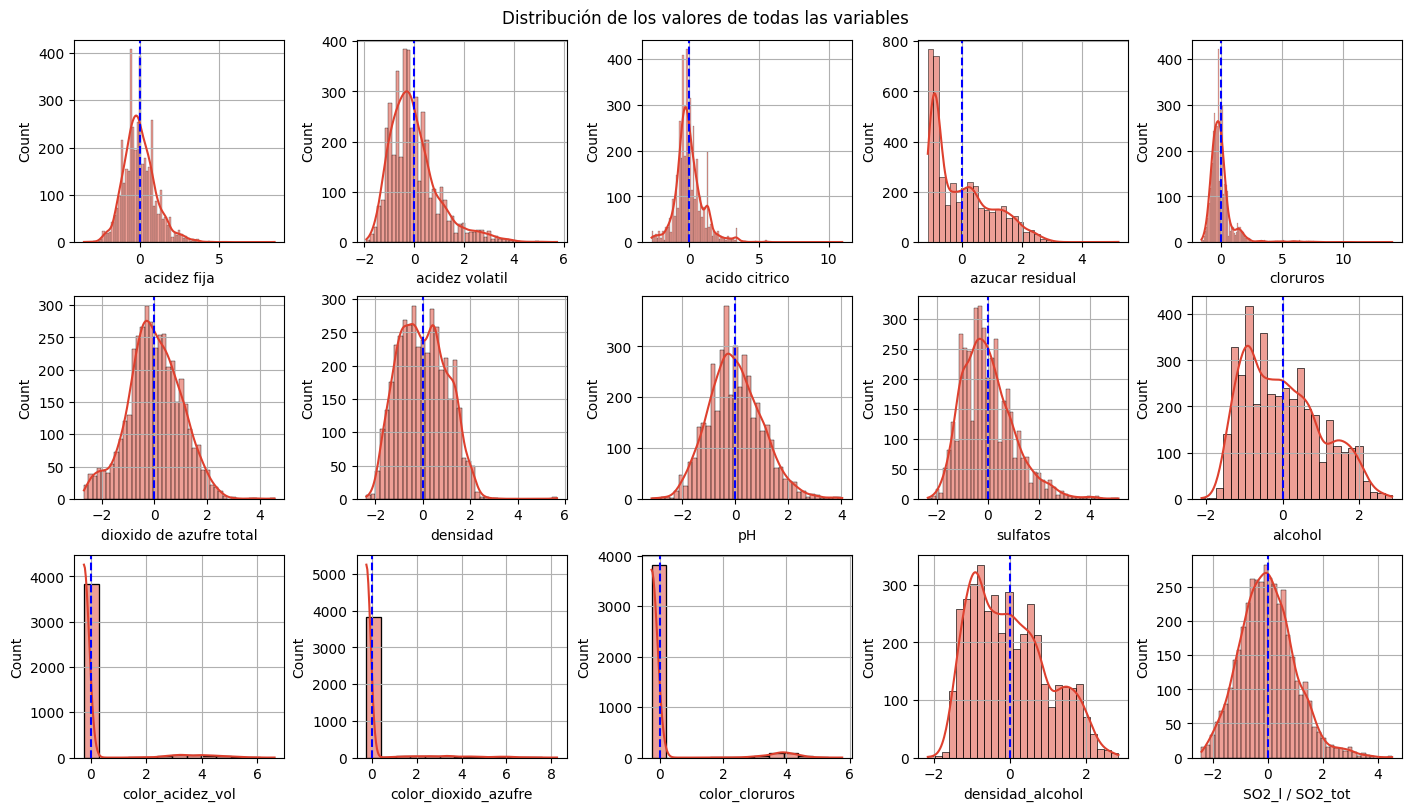

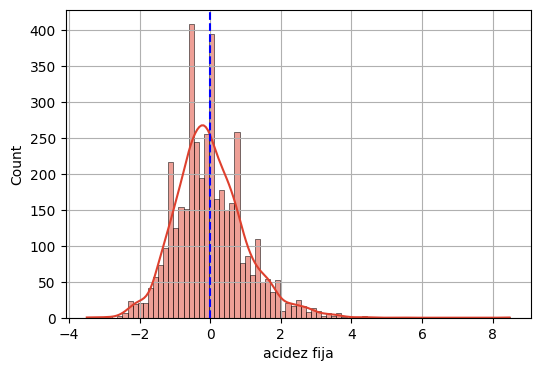

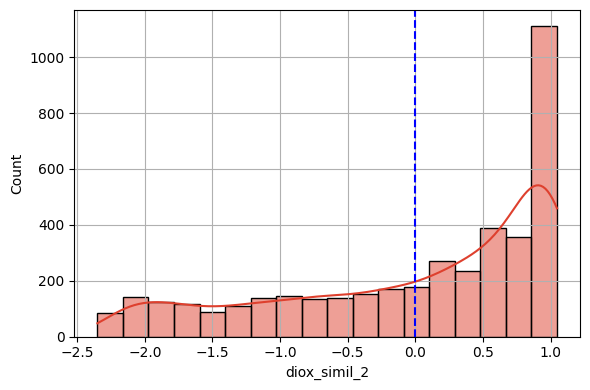

In [ ]:
plotear_distribucion_variables(df_out_std, 5)

# Transformaciones Logaritmicas

- La variable **azucar residual** y **cloruros** podrían beneficiarse de una transformación logaritmica ya que disponen de una larga cola hacia la derecha

In [ ]:
df_out_std['azucar residual'] = df_out_std['azucar residual'].apply(np.log)
df_out_std['cloruros'] = df_out_std['cloruros'].apply(np.log)

- Visualizamos tras aplicar el logaritmo

ic| n_rows: 3


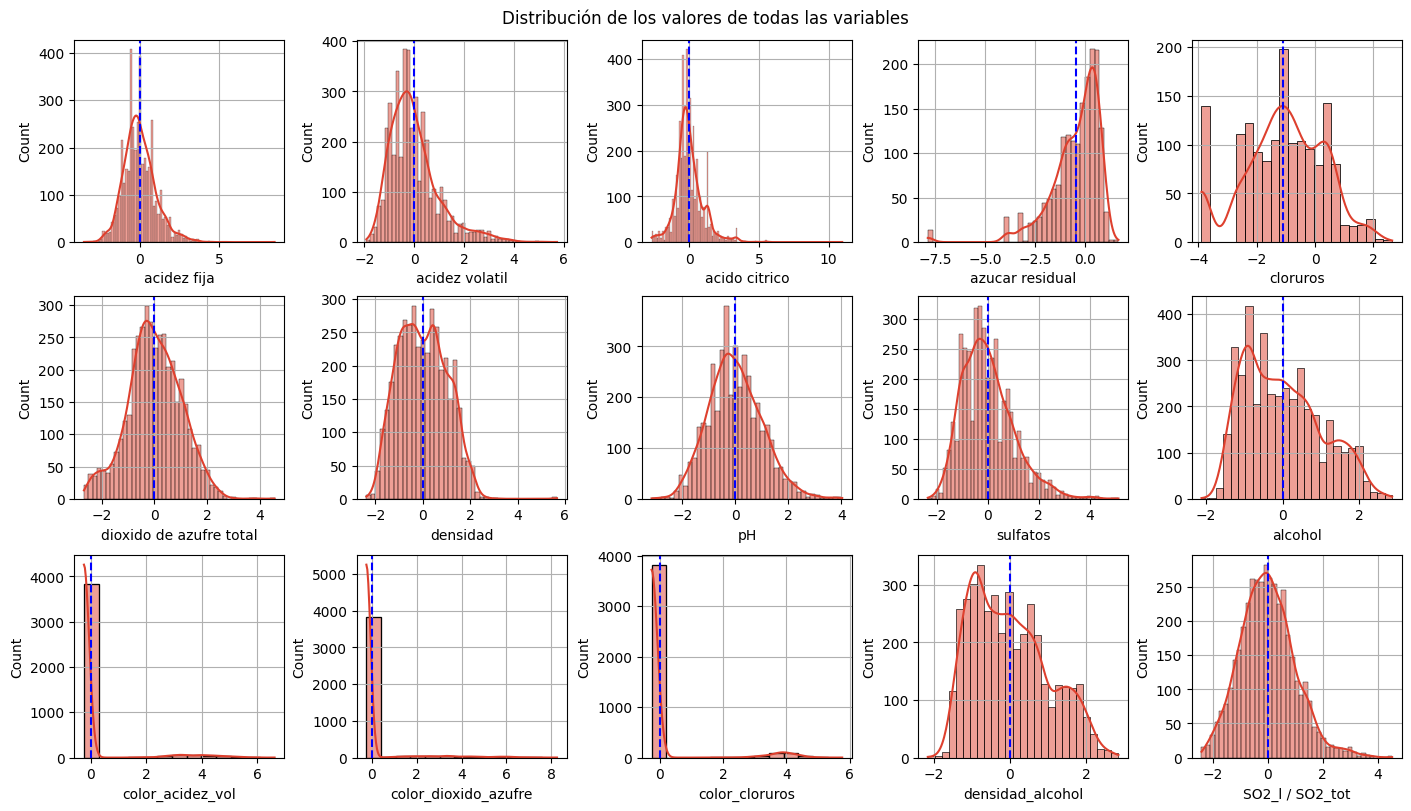

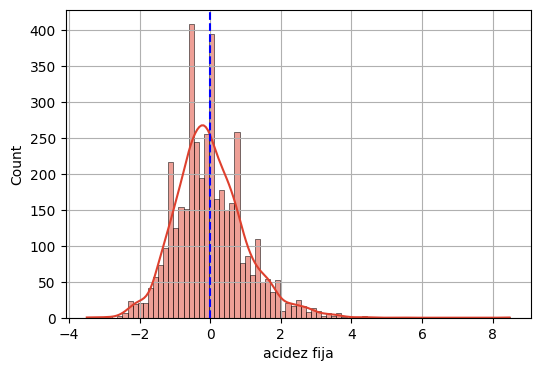

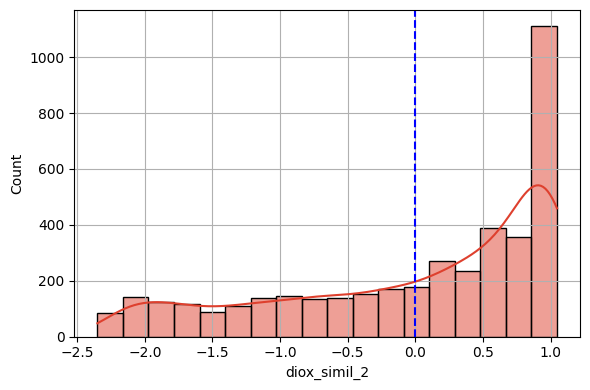

In [ ]:
plotear_distribucion_variables(df_out_std, 5)

# Agrupando el preprocesado - **WineDatasetTransformer**

- Vamos a agrupar todos los pre procesados que hemos visto en una única clase con los argumentos personalizables para hacer pruebas con ellos y que sea más sencillo aplicar las transformaciones.

In [12]:
class WineDatasetTransformer(TransformerMixin, BaseEstimator):
    """Transformer específico del proyecto AidTec"""
    def __init__(self,
                 corregir_alcohol: bool = True,
                 corregir_densidad: bool = True,
                 color_interactions: bool = True,
                 densidad_alcohol_interaction: bool = True,
                 ratio_diox: bool = True,
                 rbf_diox: bool = True,
                 remove_outliers: bool = False,
                 standardize: bool = False,
                 log_transformation: list[str] = None,
                 drop_columns: list[str] = None,
                 shuffle: bool = True) -> None:
        """Inicializa los parámetros de transformación
        a aplicar"""
        self.corregir_alcohol = corregir_alcohol
        self.corregir_densidad = corregir_densidad
        self.color_interactions = color_interactions
        self.densidad_alcohol_interaction = densidad_alcohol_interaction
        self.ratio_diox = ratio_diox
        self.rbf_diox = rbf_diox
        self.sf_coords = 27, 126 # Coordenadas de los clusters de diox az total
        self.isolation_forest = IsolationForest(random_state=42)
        self.gamma_1 = 0.003
        self.gamma_2 = 2.5e-4
        self.remove_outliers = remove_outliers
        self.standardize = standardize
        self.sc = StandardScaler()
        self.oh_encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
        self.log_transformation_list = log_transformation
        self.drop_columns_list = drop_columns
        self.shuffle = shuffle

    def _filtrar_alcohol_malos(self, feature: pd.Series) -> pd.Series:
        """Devuelve los valores de alcohol potencialmente erróneos"""
        return feature[feature.apply(len) > 5]

    def _corregir_valores_alcohol(self, feature: pd.Series) -> pd.Series:
        """Corrige los valores de alcohol corrigiendo las comas.
        Acepta la feature y devuelve la misma feature con los
        datos corregido y cambiada a float.
        """
        # Copiamos la feature
        feature_ = feature.copy()
        # Filtramos los valores erroneos
        feature_malos = self._filtrar_alcohol_malos(feature_)

        # Quitamos los puntos
        if feature_malos.dtype != 'O':
            raise ValueError('La feature debe ser de tipo object')

        feature_limpio = feature_malos.str.replace('.', '', regex=False)
        # Si empieza por 8 o 9 agregamos un 0 delante
        feature_limpio[feature_limpio.str.startswith(('8', '9'))] = \
            '0' + feature_limpio
        # Añadimos el punto desde la posición 2
        feature_limpio = feature_limpio.str.slice(0, 2) + '.' + \
            feature_limpio.str.slice(1, 4)
        # Modificamos en el dataset completo
        feature_[feature_malos.index] = feature_limpio
        return feature_.astype('float64') # Devolvemos el tipo

    def _corregir_valores_densidad(self, feature: pd.Series) -> pd.Series:
        """Corrige los valores de densidad debido al mal emplazamiento
        de las comas dividiendo entre 10 hasta llegar a valores alrededor
        de 1."""
        # Copiamos la feature
        feature_ = feature.copy()
        # Filtramos los valores erroneos
        feature_malos = feature_[feature_ > 2]
        # Creamos función que procese los valores malos
        def dividir_por_diez(valor: float) -> float:
            while valor >= 10:  # Mientras el valor sea igual o mayor a 10,
                valor /= 10  # dividir entre 10.
            return valor

        feature_corregidos = feature_malos.apply(dividir_por_diez)

        # Sustituimos los corregidos
        feature_[feature_malos.index] = feature_corregidos

        return feature_

    def fit(self,
            X: np.ndarray | pd.DataFrame,
            y=None
            ) -> 'WineDatasetTransformer':
        coord1, coord2 = self.sf_coords
        self.rbf_transformer_1 = FunctionTransformer(rbf_kernel,
                                                kw_args=dict(Y=[[coord1]],
                                                             gamma=self.gamma_1))
        self.rbf_transformer_2 = FunctionTransformer(rbf_kernel,
                                            kw_args=dict(Y=[[coord2]],
                                                         gamma=self.gamma_2))
        # Validación de logs
        if self.log_transformation_list is not None:
            for col in self.log_transformation_list:
                if col not in X:
                    raise ValueError(f'La columna {col} no es correcta')

        # Validacion drops
        if self.drop_columns_list is not None:
            for col in self.drop_columns_list:
                if col not in X:
                    raise ValueError(f'La columna {col} no es correcta')


        return self

    def transform(self,
                  X: pd.DataFrame
                  ) -> pd.DataFrame:
        X_ = X.copy()
        if self.corregir_alcohol:
            # Corregimos alcohol
            X_['alcohol'] = self._corregir_valores_alcohol(X_['alcohol'])
        if self.corregir_densidad:
            # Corregimos densidad
            X_['densidad'] = self._corregir_valores_densidad(X_['densidad'])

        # Binarizamos la variable color
        X_['color'] = self.oh_encoder.fit_transform(X_[['color']]).astype('int64')

        if self.remove_outliers:
            self.outlier_pred = self.isolation_forest.fit_predict(X_)
            X_ = X_.iloc[self.outlier_pred == 1, :].reset_index(drop=True)

        if self.standardize:
            X_ = pd.concat([
                pd.DataFrame(
                self.sc.fit_transform(X_.select_dtypes('float64')),
                columns=self.sc.feature_names_in_,
                index=X_.index,
            ),
                X_.select_dtypes('int64')
            ], axis=1)
        if self.color_interactions:
            # Interacciones con la variable color
            X_['color_acidez_vol'] = X_['color'] * X_['acidez volatil']
            X_['color_dioxido_azufre'] = X_['color'] * X_['dioxido de azufre total']
            X_['color_cloruros'] = X_['color'] * X_['cloruros']
        if self.densidad_alcohol_interaction:
            # Interaccion densidad alcohol
            X_['densidad_alcohol'] = X_['densidad'] * X_['alcohol']
        if self.ratio_diox:
            X_['SO2_l / SO2_tot'] = X_['dioxido de azufre libre'] / X_['dioxido de azufre total']
            # Creamos variables distancias a los modos de diox azufre total
        if self.rbf_diox:
            diox_simil_1 = self.rbf_transformer_1.transform(
                X_[["dioxido de azufre total"]]
                )
            diox_simil_2 = self.rbf_transformer_2.transform(
                X_[["dioxido de azufre total"]]
                )
            X_['diox_simil_1'] = diox_simil_1
            X_['diox_simil_2'] = diox_simil_2

        if self.log_transformation_list is not None:
            for col in self.log_transformation_list:
                X_[col] = X_[col].apply(np.log)

        if self.drop_columns_list is not None:
            X_ = X_.drop(columns=self.drop_columns_list)

        if self.shuffle:
            X_ = X_.sample(len(X_), random_state=42)

        return X_

    def get_feature_names_out(self, names=None):
        super().get_feataure_names_out()

# Entrenamiento de modelos

Creamos una lista de modelos para evaluar de forma sencilla sobre diferentes configuraciones de Dataset según hemos visto más arriba.

In [13]:
lista_modelos = [
    DummyClassifier(random_state=42), # Referencia a superar
    SVC(random_state=42),
    GaussianNB(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    MultiStageClassifier(
        *[RandomForestClassifier(random_state=42)] * 3
        ),
    VotingClassifier(
    estimators=[
        ('rfc', RandomForestClassifier(random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('multistage', MultiStageClassifier(
        *[RandomForestClassifier(random_state=42)] * 3
        ))
    ],
    voting='hard'
    )
]

In [14]:
# Para a codificar los labels
label_encoder = LabelEncoder()

## Dataset Base

Utilizando la clase transformer personalizada, vamos a empezar generando un dataset **sin interacciones**. Solo corregiremos los valores de alcohol y densidad para tener un datset sin errores de datos

In [ ]:
wt = WineDatasetTransformer(
    color_interactions=False,
    densidad_alcohol_interaction=False,
    ratio_diox=False,
    rbf_diox=False
)

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index] # El wt shufflea por defecto

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                         GaussianNB                         
             accuracy: 0.4069 > [0.41923077 0.43653846 0.39423077 0.37536092 0.40904716]
             balanced accuracy: 0.2904 > [0.24979964 0.25439211 0.39412476 0.31786842 0.2357105 ]

                    KNeighborsClassifier                    
             accuracy: 0.4650 > [0.47596154 0.44903846 0.46057692 0.46294514 0.47641963]
             balanced accuracy: 0.2164 > [0.21817271 0.19964871 0.20236397 0.20704387 0.25498798]

    

- El RandomForest es el modelo que mejor rendimiento tiene en cross validation

### Dataset con interacciones

In [ ]:
wt = WineDatasetTransformer(
    color_interactions=True,
    densidad_alcohol_interaction=True,
    ratio_diox=True,
    rbf_diox=True
)

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index] # El wt shufflea por defecto

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                         GaussianNB                         
             accuracy: 0.2468 > [0.29903846 0.26826923 0.20384615 0.18864293 0.27430221]
             balanced accuracy: 0.2474 > [0.29816611 0.17949209 0.29375501 0.27325204 0.1922324 ]

                    KNeighborsClassifier                    
             accuracy: 0.4802 > [0.49326923 0.46923077 0.46923077 0.47545717 0.49374398]
             balanced accuracy: 0.2290 > [0.23485627 0.21899273 0.21315523 0.21510846 0.2627298 ]

    

- Vuelve a ser el RandomForest el mejor clasificador, los rendimientos son prácticamente iguales que en el caso anterior

### Dataset con interacciones y Eliminamos variables con poca información : **year** y **color**.

In [ ]:
wt = WineDatasetTransformer(
    color_interactions=False,
    drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4417 > [0.44230769 0.43942308 0.44038462 0.44177093 0.44465833]
             balanced accuracy: 0.1433 > [0.14285714 0.14378882 0.14322251 0.14265619 0.14394768]

                         GaussianNB                         
             accuracy: 0.3988 > [0.42307692 0.41634615 0.375      0.37536092 0.40423484]
             balanced accuracy: 0.3077 > [0.28027626 0.26708904 0.40987734 0.3453646  0.23586531]

                    KNeighborsClassifier                    
             accuracy: 0.4808 > [0.50865385 0.47211538 0.46057692 0.48123195 0.48123195]
             balanced accuracy: 0.2247 > [0.23100169 0.21482114 0.20800198 0.22369748 0.24582135]

    

- El número 1 sigue siendo el RandomForest. La accuracy ha mejorado ligeramente con respecto al caso anterior. Parece que eliminar variables que aportan poca información ayuda al modelo

### Dataset con interacciones y Eliminamos variables con poca información : **year** y **color** y variables **alcohol** y **densidad**

Vamos a probar a eliminar también las variables **alcohol** y **densidad** ya que están representadas mediante la interacción entre ambas

In [ ]:
wt = WineDatasetTransformer(
    color_interactions=False,
    drop_columns=['year', 'color', 'alcohol', 'densidad', 'dioxido de azufre libre'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4432 > [0.44230769 0.44423077 0.44038462 0.44177093 0.44754572]
             balanced accuracy: 0.1434 > [0.14285714 0.14413592 0.14267446 0.14254658 0.14454277]

                         GaussianNB                         
             accuracy: 0.4080 > [0.43461538 0.39519231 0.39615385 0.38979788 0.42444658]
             balanced accuracy: 0.2785 > [0.25531191 0.19022627 0.36276114 0.3415396  0.24261988]

                    KNeighborsClassifier                    
             accuracy: 0.4975 > [0.50961538 0.49519231 0.49711538 0.51299326 0.47256978]
             balanced accuracy: 0.2420 > [0.22853077 0.25478196 0.25338662 0.22632648 0.24683484]

    

Apenas hay variaciones con respecto a cual es el mejor clasificador ni con respecto a las accuracies. El mejor clasificador sigue siendo el RandomForest y el MultiStage ( 3 RandomForest)

### Tuneamos algunos modelos

- Los mejores modelos han resultado ser el **RandomForest** y el **MultiStage** formado por 3 RandomForest

Por su simplicidad y viendo que la diferencia en términos de accuracy no es demasiado elevada, vamos a centrarnos en el RandomForest exclusivamente y buscar los mejores parámetros

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor params {'criterion': 'gini', 'n_estimators': 1000}
Mejores resultados 0.6744941511808691
CPU times: user 11min 17s, sys: 1.15 s, total: 11min 18s
Wall time: 11min 15s


param_criterion param_n_estimators  mean_test_score  std_test_score
3             gini               1000         0.674494        0.012932
2             gini                950         0.674302        0.012748
1             gini                900         0.673532        0.013392
7         log_loss               1000         0.673340        0.012253
11         entropy               1000         0.673340        0.012253
6         log_loss                950         0.672379        0.012358
10         entropy                950         0.672379        0.012358
5         log_loss                900         0.672186        0.011106
9          entropy                900         0.672186        0.011106
0             gini                100         0.668722        0.009963

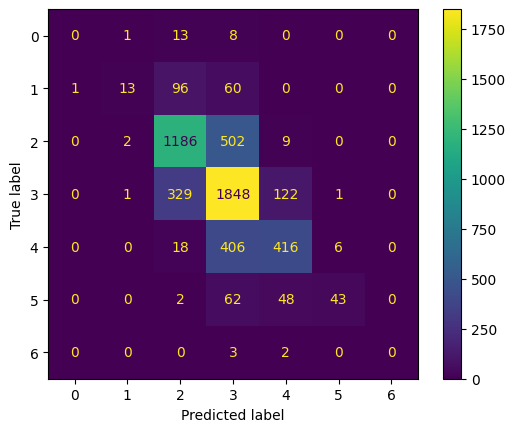

In [ ]:
%%time

param_grid = {
    'n_estimators': [100, 900, 950, 1000],
    'criterion': ['gini', 'log_loss', 'entropy']
}

# Configura RandomizedSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    scoring=('accuracy')
    )

grid.fit(X_transformed, y_transformed)

# Mejores parámetros y puntuación
best_rf_clf_tuned = grid.best_estimator_
print("Mejor params", grid.best_params_)
print("Mejores resultados", grid.best_score_)


ConfusionMatrixDisplay.from_predictions(y_transformed,
                                        cross_val_predict(
                                            best_rf_clf_tuned,
                                            X_transformed,
                                            y_transformed,
                                            cv=StratifiedKFold(n_splits=5),
                                            ));

# Vemos los resultados tb en forma de dataframe
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

Con los mejores parámetros del RandomForest podemos subir la accuracy a 0.6745

Podemos probar la accuracy ahora de un MultiStage con 3 RandomForest con los parámetros encontrados en el GridSearch anterior.

In [ ]:
ms_clf_base = MultiStageClassifier(
        *[RandomForestClassifier(
            random_state=42,
            n_estimators=900)
        ] * 3
        )
ms_clf_base

MultiStageClassifier(model_extreme=RandomForestClassifier(n_estimators=900,
                                                          random_state=42),
                     model_middle=RandomForestClassifier(n_estimators=900,
                                                         random_state=42),
                     model_stage1=RandomForestClassifier(n_estimators=900,
                                                         random_state=42))

In [ ]:
%%time

scores = cross_val_score(
    ms_clf_base,
    X_transformed,
    y_transformed,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy')

print(scores.mean(), scores)

0.6694926704671651 [0.66346154 0.65480769 0.66730769 0.66506256 0.69682387]
CPU times: user 1min 3s, sys: 123 ms, total: 1min 3s
Wall time: 1min 3s


- El resultado es ligeramente inferior al RandomForest único de 1 sola etapa

## Dataset con transformaciones logarítimicas

- Como vimos anteiormente, la distribución de las varaibles **cloruros** y **azucar residual** tiene una cola hacia la derecha. Estas variables podrían beneficiarse de una transformación logarítmica.

- Vamos a comprobar si superan los valores del dataset base

In [ ]:
wt = WineDatasetTransformer(
    log_transformation=['azucar residual', 'cloruros'],
    drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4675 > [0.46346154 0.48173077 0.46346154 0.45717036 0.47160731]
             balanced accuracy: 0.1559 > [0.15438436 0.16238582 0.1540738  0.1519962  0.15663927]

                         GaussianNB                         
             accuracy: 0.2763 > [0.32307692 0.29807692 0.21538462 0.20885467 0.3358999 ]
             balanced accuracy: 0.2620 > [0.31492687 0.19217518 0.30419085 0.2798983  0.21863043]

                    KNeighborsClassifier                    
             accuracy: 0.4838 > [0.49519231 0.47596154 0.46538462 0.47449471 0.50818094]
             balanced accuracy: 0.2318 > [0.23687932 0.22125651 0.20985057 0.21844321 0.27237498]

    

- Los valores se mantienen prácticamente iguales.

## Dataset Equilibrado

### SMOTE

In [ ]:
wt = WineDatasetTransformer(drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

smote = SMOTE(random_state=42,
                k_neighbors=4)

X_smote, y_smote = smote.fit_resample(X_transformed, y_transformed)

In [ ]:
train_models_basic_cross_val(X_smote, y_smote, lista_modelos)

ic| skf: StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.1428 > [0.14276847 0.14276847 0.14276847 0.14276847 0.14276847 0.14276847
 0.14276847 0.14285714 0.14285714 0.14285714]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.3898 > [0.38733706 0.39540658 0.3786468  0.40099317 0.40657976 0.37057728
 0.37306021 0.39378882 0.39503106 0.39627329]
             balanced accuracy: 0.3898 > [0.3872738  0.39564142 0.37887123 0.40095991 0.40670055 0.37018902
 0.37301767 0.39378882 0.39503106 0.39627329]

                         GaussianNB                         
             accuracy: 0.3377 > [0.34636872 0.33767846 0.34078212 0.34016139 0.35319677 0.31905649
 0.32650528 0.33975155 0.34409938 0.32981366]
             balanced accuracy: 0.3377 > [0.34638219 0.3378398  0.340983

#### Tunear el mejor

Vemos que el que mejor resultado nos da es el **VotingClassifier** asi que vamos a tunear sus hiperparámetros

In [ ]:
v_clf_smote = VotingClassifier(
    estimators=[
        ('rfc', RandomForestClassifier(random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('multistage', MultiStageClassifier(
            model_stage1=RandomForestClassifier(
                random_state=42,
                n_estimators=443, # Fine tuning anterior
            ),
            model_middle=RandomForestClassifier(
                random_state=42,
                n_estimators=900, # Fine tuning anterior
            ),
            model_extreme=RandomForestClassifier(
                random_state=42,
                n_estimators=164, # Fine tuning anterior
            ),

        ))
    ],
    voting='hard'
    )
v_clf_smote

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_ty...
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('knn', KNeighborsClassifier()),
                             ('multistage',
                              MultiStageClassifier(model_extreme=RandomForestClassifier(n_estimators=164,
                                                                                        random_state=42),
                                                   model_middle=RandomForestClassifier(n_estimators=900,
                                                                                       random_state=42),
                                                   model_stage1=RandomForestClassifier(n_estimators=443,
                                                                                       random_state=42)))])

Vamos a realizar un RandomSearch con algunos parámetros a tunear de los modelos

🛑 **OJO**: esta celda tarda más de 5h30 en ejecutar para n_iter=50 y cv=10

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor params {'knn__n_neighbors': 7, 'rfc__criterion': 'entropy', 'rfc__n_estimators': 761, 'xgb__gamma': 0.045129263221680205, 'xgb__learning_rate': 0.15439975445336496}
Mejores resultados 0.9025081788440567


param_knn__n_neighbors param_rfc__criterion param_rfc__n_estimators  \
2                      7              entropy                     761   
0                      9                 gini                     370   
1                      9             log_loss                     566   
3                      8             log_loss                     485   
4                      6             log_loss                     121   

  param_xgb__gamma param_xgb__learning_rate  mean_test_score  std_test_score  
2         0.045129                   0.1544         0.902508        0.012910  
0         0.585595                 0.129732         0.900036        0.011799  
1          0.07998                  0.10185         0.899746        0.011089  
3          0.14546                 0.046681         0.894875        0.011415  
4         0.005653                 0.014612         0.891385        0.010501

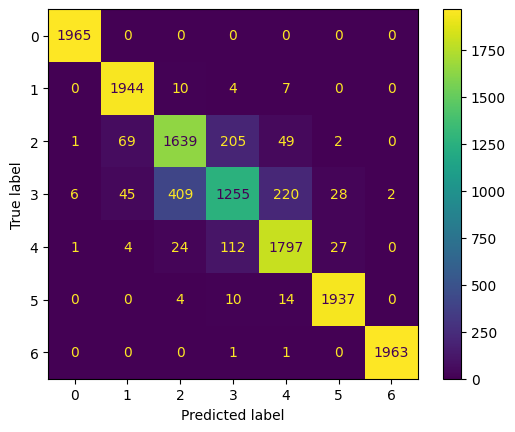

In [ ]:
%%time

param_dist = {
    'rfc__criterion': ['gini', 'log_loss', 'entropy'],
    'rfc__n_estimators': randint(100, 1000),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'knn__n_neighbors': randint(3, 10),
    'xgb__gamma': uniform(0, 0.8),
}

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=v_clf_smote,
    param_distributions=param_dist,
    n_iter=5,
    cv=5,
    verbose=1,
    #n_jobs=multiprocessing.cpu_count(),
    random_state=42,
    scoring=('accuracy')
    )

random_search.fit(X_smote, y_smote)

# Mejores parámetros y puntuación
best_v_clf_smote = random_search.best_estimator_
print("Mejor params", random_search.best_params_)
print("Mejores resultados", random_search.best_score_)


ConfusionMatrixDisplay.from_predictions(y_smote,
                                        cross_val_predict(
                                            best_v_clf_smote,
                                            X_smote,
                                            y_smote,
                                            cv=10,
                                            ));

# Vemos los resultados tb en forma de dataframe
resultados = pd.DataFrame(random_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

In [ ]:
best_v_clf_smote

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(criterion='entropy',
                                                     n_estimators=761,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamm...
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('knn', KNeighborsClassifier(n_neighbors=7)),
                             ('multistage',
                              MultiStageClassifier(model_extreme=RandomForestClassifier(n_estimators=164,
                                                                                        random_state=42),
                                                   model_middle=RandomForestClassifier(n_estimators=900,
                                                                                       random_state=42),
                                                   model_stage1=RandomForestClassifier(n_estimators=443,
                                                                                       random_state=42)))])

### ADASYN

In [ ]:
wt = WineDatasetTransformer(drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

ada = ADASYN(random_state=42,
                n_neighbors=4)

X_ada, y_ada = ada.fit_resample(X_transformed, y_transformed)

In [ ]:
train_models_basic_cross_val(X_ada, y_ada, lista_modelos)

ic| skf: StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.1455 > [0.14560099 0.14569126 0.14569126 0.14569126 0.14569126 0.14569126
 0.14569126 0.1450713  0.1450713  0.1450713 ]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.3694 > [0.41263941 0.39925604 0.39429634 0.38809671 0.31680099 0.38127712
 0.35709857 0.37817731 0.35895846 0.30750155]
             balanced accuracy: 0.3687 > [0.41177469 0.39841798 0.39352255 0.38701559 0.31587084 0.38046609
 0.35620971 0.3776928  0.35868969 0.30711731]

                         GaussianNB                         
             accuracy: 0.3434 > [0.41821561 0.38251705 0.33849969 0.35151891 0.33539988 0.32920025
 0.32176069 0.35585865 0.3316801  0.26906386]
             balanced accuracy: 0.3428 > [0.41771384 0.38198186 0.337889

### SMOTEENN

In [ ]:
wt = WineDatasetTransformer(drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

sme = SMOTEENN(random_state=42,
               smote=smote) # Usamos el objeto SMOTE definido anteriormente

X_sme, y_sme = sme.fit_resample(X_transformed, y_transformed)

In [ ]:
train_models_basic_cross_val(X_sme, y_sme, lista_modelos)

ic| skf: StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.2077 > [0.20758123 0.20758123 0.20758123 0.20758123 0.20758123 0.20848375
 0.20776874 0.20776874 0.20776874 0.20776874]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.5060 > [0.50270758 0.51805054 0.49729242 0.52075812 0.52075812 0.50180505
 0.47877145 0.51309846 0.50225836 0.50496838]
             balanced accuracy: 0.3929 > [0.39111742 0.40647497 0.38684177 0.4070771  0.40413852 0.39220723
 0.37201565 0.3993137  0.38408267 0.38590222]

                         GaussianNB                         
             accuracy: 0.4198 > [0.42960289 0.41606498 0.41516245 0.42418773 0.44043321 0.40252708
 0.41463415 0.4200542  0.42095754 0.41463415]
             balanced accuracy: 0.3597 > [0.36784892 0.34864535 0.357932

- De entre los datasets balanceados, la técnica SMOTEEN es la que mejor resultados da

- Hay que tener muy en cuenta que las accuracies tan elevadas que vemosson debidas al remuestreo. Al hacer CV, el modelo verá muchas muestras repetidas que ya había encontrado en la fase de entrenamiento y esto se traduce en elevadas accuracies. Habrá que tenerlo en cuenta para el modelo final

## Dataset sin outliers

In [ ]:
wt = WineDatasetTransformer(remove_outliers=True)

X = df_raw.drop(columns=['calidad'])
y = df_raw['calidad']

X_transformed = wt.fit_transform(X)

y_transformed = y[wt.outlier_pred == 1].reset_index(drop=True)
y_transformed = label_encoder.fit_transform(y_transformed)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4501 > [0.45082873 0.44972376 0.44972376 0.45022124 0.45022124]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.4501 > [0.45082873 0.44972376 0.44972376 0.45022124 0.45022124]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                         GaussianNB                         
             accuracy: 0.0960 > [0.09171271 0.09723757 0.09392265 0.10619469 0.09070796]
             balanced accuracy: 0.2187 > [0.26264421 0.18842796 0.18714417 0.20242486 0.25270331]

                    KNeighborsClassifier                    
             accuracy: 0.4860 > [0.47513812 0.47734807 0.49834254 0.5        0.4789823 ]
             balanced accuracy: 0.2236 > [0.21110948 0.22118537 0.22308227 0.22919313 0.23320621]

    

## Dataset estandarizado

In [ ]:
wt = WineDatasetTransformer(drop_columns=['year', 'color'],
                            standardize=True)

X = df_raw.drop(columns=['calidad'])
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt.fit_transform(X)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4427 > [0.44230769 0.44230769 0.44230769 0.4427334  0.44369586]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.5225 > [0.51346154 0.49711538 0.53173077 0.54186718 0.52839269]
             balanced accuracy: 0.1900 > [0.18534892 0.18028864 0.19267446 0.20016766 0.19142779]

                         GaussianNB                         
             accuracy: 0.2482 > [0.27019231 0.25673077 0.22596154 0.17998075 0.30798845]
             balanced accuracy: 0.2570 > [0.25816705 0.21676389 0.32003194 0.27026762 0.2199205 ]

                    KNeighborsClassifier                    
             accuracy: 0.5481 > [0.54326923 0.56057692 0.5375     0.53897979 0.56015399]
             balanced accuracy: 0.2711 > [0.26341415 0.25212627 0.29027493 0.25304774 0.29662631]

    

## Dataset sin outliers y estandarizado

In [ ]:
wt = WineDatasetTransformer(remove_outliers=True,
                            standardize=True,
                            drop_columns=['year', 'color'])

X = df_raw.drop(columns=['calidad'])
y = df_raw['calidad']

X_transformed = wt.fit_transform(X)

y_transformed = y[wt.outlier_pred == 1].reset_index(drop=True)
y_transformed = label_encoder.fit_transform(y_transformed)
y_transformed = y_transformed[X_transformed.index]

In [ ]:
train_models_basic_cross_val(X_transformed, y_transformed, lista_modelos)

ic| skf: StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


  0%|          | 0/9 [00:00<?, ?it/s]

                      DummyClassifier                       
             accuracy: 0.4501 > [0.45082873 0.44972376 0.44972376 0.45022124 0.45022124]
             balanced accuracy: 0.1429 > [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]

                            SVC                             
             accuracy: 0.5344 > [0.51933702 0.51712707 0.56353591 0.5409292  0.53097345]
             balanced accuracy: 0.1930 > [0.18768484 0.18642326 0.20354387 0.19373041 0.19354522]

                         GaussianNB                         
             accuracy: 0.0975 > [0.09171271 0.09723757 0.09392265 0.10951327 0.09513274]
             balanced accuracy: 0.2312 > [0.32384092 0.1932271  0.18667537 0.1985728  0.25382409]

                    KNeighborsClassifier                    
             accuracy: 0.5384 > [0.53812155 0.53370166 0.54033149 0.54867257 0.53097345]
             balanced accuracy: 0.2568 > [0.25105571 0.23908653 0.23773819 0.28138893 0.2747943 ]

    

## DenseNN

- Vamos a probar qué tal se comporta una red neuronal densa para en la predicción de la calidad del vino

### Usando Keras

#### Re muestreando (SMOTEEN)

Entrenamos una red neuronal simple para ver si mejora las accuracies de los modelos anteriores.
- Partiremos de un dataset **sin outliers y estandarizado** y re muestreado con técnica **SMOTEEN** que según hemos visto en la sección de balancear es la que mejor resultados arrojaba para todos los modelos

In [ ]:
wt = WineDatasetTransformer(remove_outliers=True,
                            standardize=True,
                            drop_columns=['year', 'color'],
                            color_interactions=True,
                            )

X = df_raw.drop(columns=['calidad'])
y = df_raw['calidad']
X_transformed = wt.fit_transform(X)
y_transformed = y[wt.outlier_pred == 1].reset_index(drop=True)
y_transformed = label_encoder.fit_transform(y_transformed)
y_transformed = y_transformed[X_transformed.index]

# Resampleamos con técnica SMOTE
smote = SMOTE(
    random_state=42,
    k_neighbors=4
    )

sme = SMOTEENN(random_state=42,
               smote=smote)

X_sme, y_sme = sme.fit_resample(X_transformed, y_transformed)

# Creamos los splits train y validation
X_nn_train, X_nn_valid, y_nn_train, y_nn_valid = train_test_split(
    X_sme, y_sme,
    test_size=0.2,
    random_state=42,
    stratify=y_sme
    )


def build_model(X_train) -> keras.Model:
    inputs = keras.Input(shape=(X_train.shape[1],), name="Input")
    features = layers.Dense(120, activation="relu", name="Capa1")(inputs)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(96, activation="relu", name="Capa2")(features)
    features = layers.Dense(32, activation="relu", name="Capa3")(features)
    features = layers.Dense(16, activation="relu", name="Capa4")(features)
    outputs = layers.Dense(7, activation="softmax", name="Output")(features)
    model_nn = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name="Modelo_Dataset_Smote")

    model_nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss="sparse_categorical_crossentropy", # Si no 'one hoteamos' hay que usar la sparse
        metrics=["accuracy"],
    )
    return model_nn

# Definimos los callbacks
# Función para reducir el lr dinámicamente
def scheduler(epoch: int, lr: float):
    if epoch < 500:
        return lr
    else:
         return lr * tf.math.exp(-0.1)

#Lista de callbakcs
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
    ),
    keras.callbacks.LearningRateScheduler(scheduler)
]

In [ ]:
%%time

# Definimos el modelo
model_nn_keras = build_model(X_nn_train)
# Entrenamos el modelo
epochs = 900

history = model_nn_keras.fit(
    X_nn_train, y_nn_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(X_nn_valid, y_nn_valid),
    verbose=0,
    #callbacks=callbacks_list,
)

val_loss = history.history["val_loss"]
train_loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

CPU times: user 2min 53s, sys: 23.3 s, total: 3min 16s
Wall time: 2min 23s


Ploteamos la loss y las accuracies

Accuracy final: 0.9738267064094543


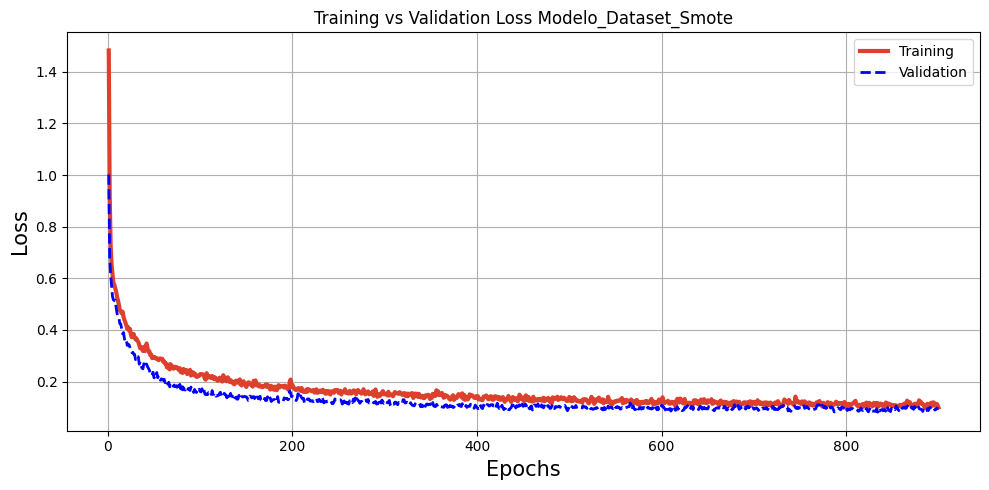

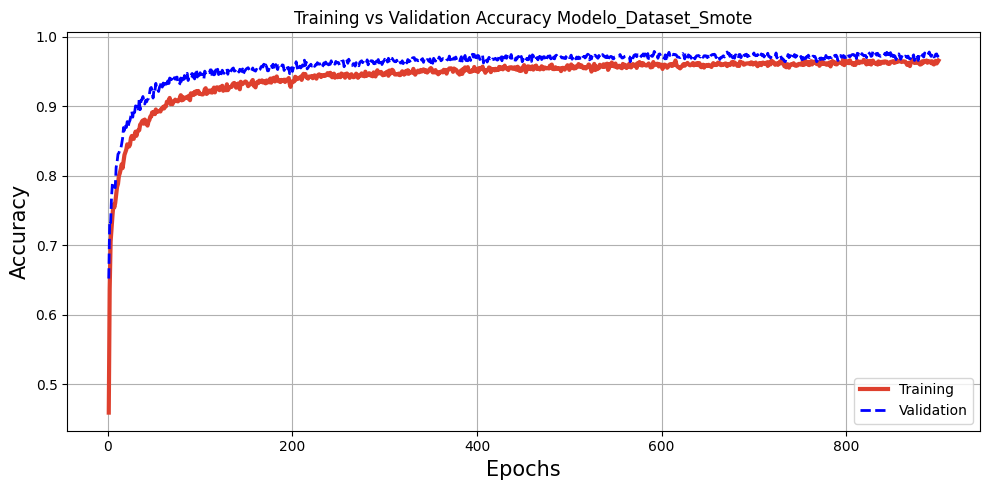

In [ ]:
print('Accuracy final:', val_accuracy[-1])

# Train & val Loss
plt.figure(figsize=(10, 5))
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.plot(range(1, len(val_loss) + 1), train_loss,
        linewidth=3,
        label='Training')
plt.plot(range(1, len(val_loss) + 1), val_loss,
        linewidth=2, linestyle='--',
        label='Validation',
         color="blue")
plt.grid(True)

plt.title(f"Training vs Validation Loss {model_nn_keras.name}")
plt.legend(loc='upper right')
plt.tight_layout()

# Train & val Accuracies
plt.figure(figsize=(10, 5))
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.plot(range(1, len(val_loss) + 1), train_accuracy,
        linewidth=3,
        label='Training')
plt.plot(range(1, len(val_loss) + 1), val_accuracy,
        linewidth=2, linestyle='--',
        label='Validation',
         color="blue")

plt.title(f"Training vs Validation Accuracy {model_nn_keras.name}")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

Mejor accuracy y número de epochs

In [ ]:
max(val_accuracy), np.argmax(val_accuracy)

(0.9805956482887268, 828)

- Parece que el modelo no overfitea el dataset ya que ambas curvas de validación y entrenamiento están casi superpuestas
- Con el dataset resampleado habiendo quitado outliers y estandarizando conseguimos una accuracy de más de entre 96 y 98% (depende del azar)
- Con el mejor clasificador (Voting) obteníamos un 89,98 % de accuracy entrenado sobre este mismo dataset

- Hay que tener en cuenta que una inmensa mayoría de muestras de este dataset han sido generadas sintéticamente lo que falsea los resultados

Guardamos el modelo keras

In [ ]:
model_nn_keras.save(model_path / 'model_nn_keras_smoteen.model')

#### Sin re muestrear

- Vamos a utilizar ahora el dataset sin remuestrear estandarizado y sin outliers

Definimos los splits y las transformaciones en el dataset

In [ ]:
wt = WineDatasetTransformer(
    remove_outliers=True,
    standardize=True,
    drop_columns=['year', 'color', 'alcohol', 'densidad'],
    color_interactions=False,
    )

X = df_raw.drop(columns=['calidad'])
y = df_raw['calidad']
X_transformed = wt.fit_transform(X)
y_transformed = y[wt.outlier_pred == 1].reset_index(drop=True)
y_transformed = label_encoder.fit_transform(y_transformed)
y_transformed = y_transformed[X_transformed.index]


# Creamos los splits train y validation
X_nn_train, X_nn_valid, y_nn_train, y_nn_valid = train_test_split(
    X_transformed, y_transformed,
    test_size=0.2,
    random_state=42,
    stratify=y_transformed,
    )

def build_model(X_train) -> keras.Model:
    inputs = keras.Input(shape=(X_train.shape[1],), name="Input")
    features = layers.Dense(120, activation="relu", name="Capa1")(inputs)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(96, activation="relu", name="Capa2")(features)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(32, activation="relu", name="Capa3")(features)
    features = layers.Dropout(0.5)(features)
    features = layers.Dense(16, activation="relu", name="Capa4")(features)
    outputs = layers.Dense(7, activation="softmax", name="Output")(features)
    model_nn = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name="Modelo_Dataset_Sin_Remuestrear")

    model_nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss="sparse_categorical_crossentropy", # Si no 'one hoteamos' hay que usar la sparse
        metrics=["accuracy"],
    )
    return model_nn

In [ ]:
%%time

# Definimos el modelo que será el mismo que en el caso anterior
model_nn_keras = build_model(X_nn_train)
# Entrenamos el modelo
epochs = 1100

history = model_nn_keras.fit(
    X_nn_train, y_nn_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(X_nn_valid, y_nn_valid),
    verbose=0,
    #callbacks=callbacks_list,
)

val_loss = history.history["val_loss"]
train_loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

CPU times: user 1min 47s, sys: 14.3 s, total: 2min 2s
Wall time: 1min 13s


Accuracy final: 0.5723757147789001


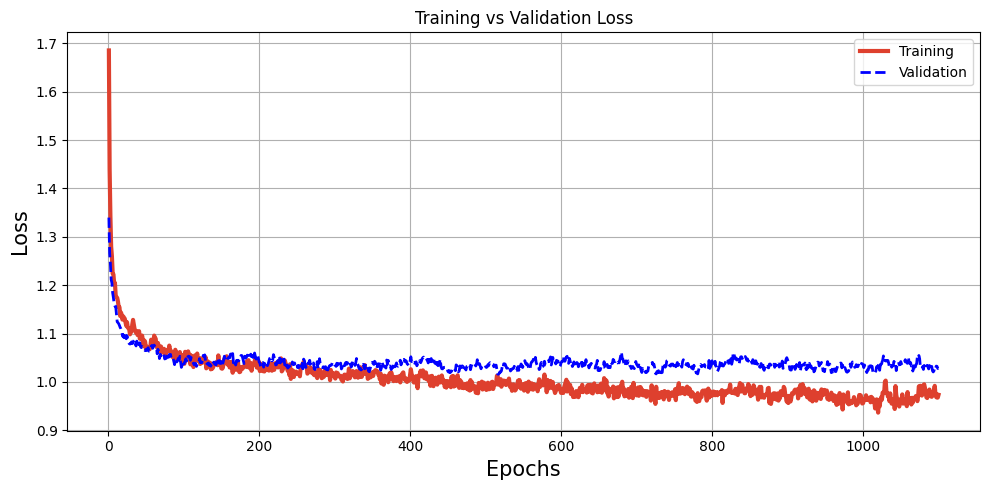

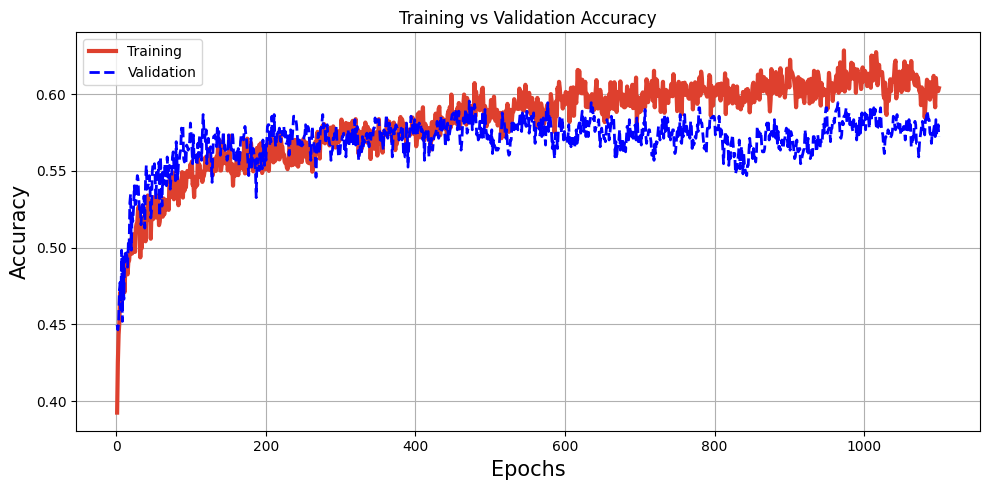

In [ ]:
print('Accuracy final:', val_accuracy[-1])

# Train & val Loss
plt.figure(figsize=(10, 5))
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.plot(range(1, len(val_loss) + 1), train_loss,
        linewidth=3,
        label='Training')
plt.plot(range(1, len(val_loss) + 1), val_loss,
        linewidth=2, linestyle='--',
        label='Validation',
         color="blue")
plt.grid(True)

plt.title("Training vs Validation Loss")
plt.legend(loc='upper right')
plt.tight_layout()

# Train & val Accuracies
plt.figure(figsize=(10, 5))
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.plot(range(1, len(val_loss) + 1), train_accuracy,
        linewidth=3,
        label='Training')
plt.plot(range(1, len(val_loss) + 1), val_accuracy,
        linewidth=2, linestyle='--',
        label='Validation',
         color="blue")

plt.title("Training vs Validation Accuracy")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

- Los resultados que se consiguen en entrenamientos en el dataset sin re muestrear están lejos de igualar los que se conseguían con un simple RandomForest

### Usando el wrapper KerasClassifier

Entrenamiento usando el wrapper **KerasClassifier**.
- Vamos a probar a entrenar la red neuronal como si fuera un objeto de scikit-learn, envolviendolo dentro de un KerasClassifier. esto nos permite agrupar más fácilmente todos los modelos

In [ ]:
%%time

# Creamos una nueva función build_model pasandole el argumento X_smote
build_model_ = partial(build_model, X_smote)

model_nn_clf_smote = KerasClassifier(
    model=build_model_,
    epochs=1000,
    batch_size=512,
    verbose=0,
    random_state=42,
    optimizer='adam'
)

# Entrenamos el modelo
model_nn_clf_smote.fit(X_smote, y_smote)

CPU times: user 3min 19s, sys: 23.1 s, total: 3min 42s
Wall time: 1min 53s


KerasClassifier(
	model=functools.partial(<function build_model at 0x78fa20505480>,        acidez fija  acidez volatil  acido citrico  azucar residual  cloruros  \
0         1.719631        2.057398      -1.873727        -0.541443  0.862636   
1         1.931387       -0.495207      -0.744701         0.909761 -0.771973   
2         0.660848        0.492898      -0.099543        -0.873147  1.362099   
3        -0.927325       -1.153943      -0.422122         1.386585  0.681013   
4         0.131457       -0.165838      -1.067280         0.391474 -0.408726   
...            ...             ...            ...              ...       ...   
13750     0.227516       -0.380326       1.035011        -0.782028 -0.785704   
13751     0.039006        0.028976       0.823929        -0.588465 -1.049506   
13752    -0.038754        0.331347       0.379722        -0.436208 -1.282936   
13753    -0.354371        0.492898      -0.205531        -0.819953 -1.290118   
13754    -0.042775        0.078585      -0.024132        -0.859107 -1.081050   

       dioxido de azufre libre  dioxido de azufre total  densidad        pH  \
0                    -1.484010                -2.234903  1.063719  0.175981   
1                    -1.245282                -0.619212  0.488686 -0.481261   
2                    -0.409735                -1.265488  0.997099  1.687637   
3                     1.798498                 0.693537  1.782510  3.002121   
4                     0.903269                 1.137852  0.516736 -0.284088   
...                        ...                      ...       ...       ...   
13750                -0.183521                -0.137274 -1.381712  0.917233   
13751                 0.566148                -0.243169 -1.484763  0.837868   
13752                 1.135964                -0.198671 -1.549141  0.620655   
13753                -0.258984                -0.767390 -1.628918  1.241835   
13754                -0.454025                -0.404280 -1.503813  1.000760   

       sulfatos   alcohol  color_acidez_vol  color_dioxido_azufre  \
0     -0.535154 -0.392175          3.124325              0.898022   
1     -0.882311  0.213640         -0.336008             -0.304630   
2      1.027054 -0.824900          1.928937              4.293743   
3     -0.621943 -1.344170         -0.336008             -0.304630   
4     -0.014418 -0.911445         -0.336008             -0.304630   
...         ...       ...               ...                   ...   
13750 -0.551252  2.012938         -0.336008             -0.304630   
13751 -0.936081  2.042060         -0.336008             -0.304630   
13752 -1.127302  1.978499         -0.336008             -0.304630   
13753  0.642689  1.720514         -0.336008             -0.304630   
13754  0.467184  1.721193         -0.336008             -0.304630   

       color_cloruros  densidad_alcohol  SO2_l / SO2_tot  diox_simil_1  \
0            2.427577         -0.371356         1.991173      3.316840   
1           -0.342283          0.233772        -1.401146     -0.289919   
2            2.875643         -0.816340         1.300848     -0.225941   
3           -0.342283         -1.330568         1.192186     -0.289921   
4           -0.342283         -0.916449        -0.059793     -0.289921   
...               ...               ...              ...           ...   
13750       -0.342283          2.013711        -0.164968     -0.289921   
13751       -0.342283          2.040034         0.945722     -0.289921   
13752       -0.342283          1.973295         1.680680     -0.289921   
13753       -0.342283          1.708407         0.414049     -0.289747   
13754       -0.342283          1.713060        -0.210991     -0.289804   

       diox_simil_2  
0         -2.019689  
1          0.456247  
2         -0.900385  
3          0.172050  
4         -0.780276  
...             ...  
13750      0.939791  
13751      0.981365  
13752      1.016333  
13753      0.103621  
13754      0.368259  

[13755 rows x 18 column

In [ ]:
with open(model_path / 'model_nn_clf_smote.pkl', 'wb') as f:
    pickle.dump(model_nn_clf_smote, f)

CPU times: user 35min, sys: 4min 27s, total: 39min 28s
Wall time: 17min 24s


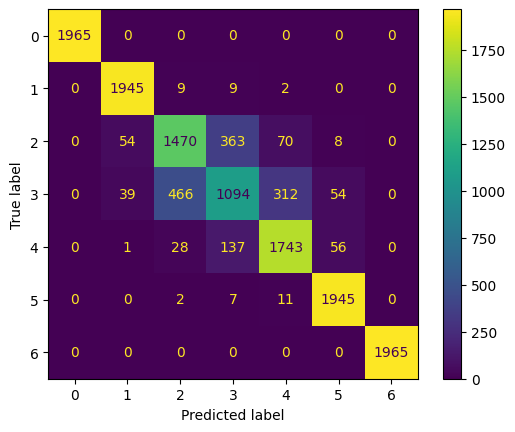

In [ ]:
%%time

ConfusionMatrixDisplay.from_predictions(y_smote,
                                        cross_val_predict(
                                            model_nn_clf_smote,
                                            X_smote,
                                            y_smote,
                                            cv=StratifiedKFold(10),
                                            ));

- Hay que recordar que este modelo ha sido entrenado con un dataset aumentado de manera sintética para igualar las muestras de cada calidad lo que hace que los resultados de la accuracy salgan excesivamente elevados.
- Habrá que verificar el rendimiento del modelo enfrentándolo con el dataset sin re muestrear
- No podemos inferir de estos resultados cómo se va a comportar este modelo en el dataset de test

- Al haberse cambiado la representatividad de cada label, el modelo no será capaz de predecir correctamente dicha representación si en el dataset de test la distribución de los labels es similar a la del train dataset (sería lo lógico).

---
---

# Recapitulando

Después de todas las pruebas, el mejor modelo es el RandomForest. Los niveles de accuracy entre distintas pruebas son muy similares y rondan el 66-67 % evaluados en cross validation estratificada con 5 folds.

Con la intención de no realizar un modelo complejo o sobrecargado sin ningún motivo, ya que se ha visto que la diferencia en rendimiento es inexistente, nos quedaremos con un **RandomForest** con los siguientes parámetros resultado del afinamiento en la sección anterior:
- Criterio: **gini**
- Estimadores: **900**

Con estos valores entrenaremos el modelo sobre el dataset completo de entrenamiento. Cabría preguntarse si no sería más conveniente entrenarlo en un dataset sobre muestreado en el que todas las muestras tengan igual representación, sin embargo, para los árboles de decisión la representación de cada clase puede ser también un criterio de decisión  a la hora de categorizar por ello es posible que resamplear el dataset introduzca sesgo y no sea de ayuda para el modelo. Sin embargo, es una técnica que vale la pena tener en cuenta.

Las transformaciones que mejor resultado ofrecían eran las siguientes:
- Interacciones entre densidad y alcohol
- Ratio de dioxido de azufre
- Similitudes con los modos de dioxido de azufre
- Eliminado de columnas poco representativas: color y year
- Eliminado de columnas densidad y alcohol que ya están representadas  con la interacción

Entrenamiento del modelo definitivo

In [59]:
# Aplicamos las transformaciones
wt_train = WineDatasetTransformer(
    shuffle=True,
    color_interactions=False,
    densidad_alcohol_interaction=True,
    remove_outliers=False,
    standardize=False,
    ratio_diox=True,
    rbf_diox=True,
    drop_columns=['color', 'year', 'densidad', 'alcohol', 'dioxido de azufre libre'],
)
label_encoder = LabelEncoder()

X = df_raw.drop(columns='calidad')
y_transformed = label_encoder.fit_transform(df_raw['calidad'])

X_transformed = wt_train.fit_transform(X)
y_transformed = y_transformed[X_transformed.index] # Para ajustar el shuffle

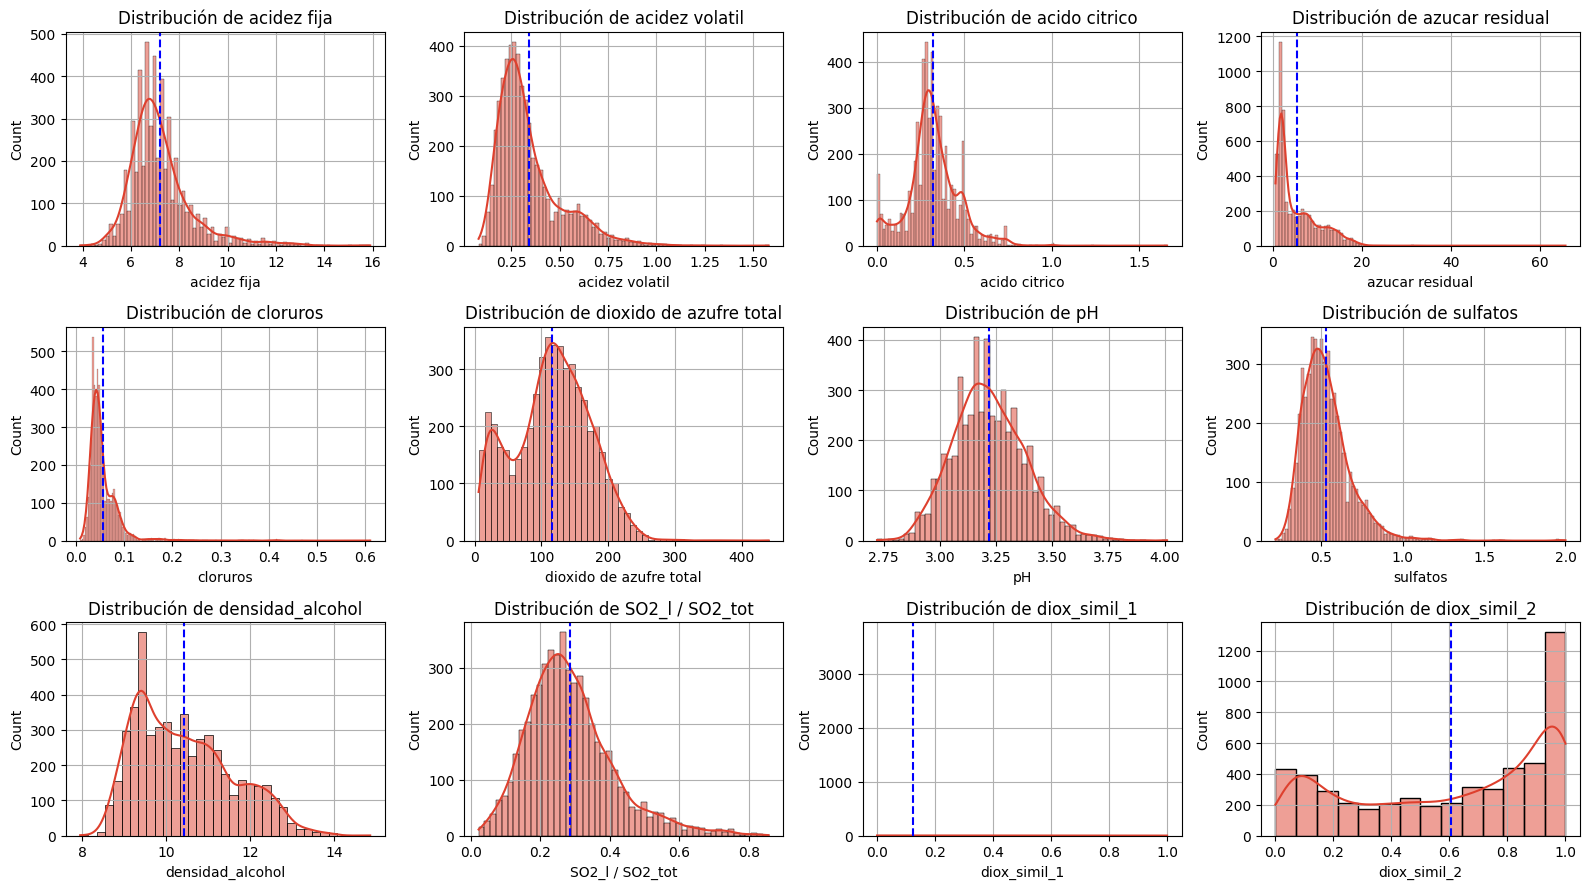

In [50]:
plotear_distribucion_variables(X_transformed)

## Modelo definitivo

Definimos el modelo. Envolveremos el modelo en la clase personalizada definida más arriba SerializableClassifier para poder guardarlo y cargarlo

In [51]:
rf = RandomForestClassifier(random_state=42,
                            criterion='gini',
                            n_estimators=900)

rf_definitivo = SerializableClassifier(rf)

Entrenamos el modelo

In [52]:
%%time

rf_definitivo.fit(X_transformed, y_transformed)

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.7 s


RandomForestClassifier(n_estimators=900, random_state=42)

Guardamos el modelo

In [53]:
rf_definitivo.save(model_path / 'rf_definitivo_notebook.joblib')

In [54]:
preds = rf_definitivo.predict(X_transformed)
accuracy_score(y_transformed, preds)

1.0

Para poder cargarlo e instanciarlo lo haríamos asi:

In [60]:
rf_definitivo_cargado = SerializableClassifier.load(model_path / 'rf_definitivo_notebook.joblib')

In [57]:
rf_definitivo_cargado

SerializableClassifier(classifier=SerializableClassifier(classifier=RandomForestClassifier(n_estimators=900,
                                                                                           random_state=42)))

In [61]:
preds = rf_definitivo_cargado.predict(X_transformed)
accuracy_score(y_transformed, preds)

1.0

In [62]:
preds

array([2, 3, 3, ..., 3, 3, 3])

Los labels están codificados hay que acordarse de revertir la transformación

## Predicciones en test

Cargamos el dataset de **test**

In [63]:
X_test_raw = pd.read_csv(raw_path / 'calidad_vino_AT_test.csv', index_col=0)
X_test_raw.head(5)

acidez fija  acidez volatil  acido citrico  azucar residual  \
muestra_id                                                                
5198                9.2            0.46           0.23              2.6   
5199                7.2            0.63           0.03              2.2   
5200                8.4            0.56           0.08              2.1   
5201                6.3            0.37           0.28              6.3   
5202                6.5            0.14           0.33              7.6   

            cloruros  dioxido de azufre libre  dioxido de azufre total  \
muestra_id                                                               
5198           0.091                     18.0                     77.0   
5199           0.080                     17.0                     88.0   
5200           0.105                     16.0                     44.0   
5201           0.034                     45.0                    152.0   
5202           0.050                     53.0                    189.0   

            densidad    pH  sulfatos alcohol   color  year  calidad  
muestra_id                                                           
5198         0.99922  3.15      0.51     9.4   tinto  2024      NaN  
5199         0.99745  3.53      0.58     9.8   tinto  2024      NaN  
5200         0.99580  3.13      0.52    11.0   tinto  2024      NaN  
5201         0.99210  3.29      0.46    11.6  blanco  2024      NaN  
5202         0.99660  3.25      0.49     8.6  blanco  2024      NaN

In [34]:
X_test_raw.alcohol.dtype

dtype('O')

In [35]:
X_test_raw.densidad.describe()

count    1299.000000
mean        1.653699
std         7.327905
min         0.987420
25%         0.992190
50%         0.994950
75%         0.997100
max       100.315000
Name: densidad, dtype: float64

- Como vemos, en el dataset test los valores de densidad y alcohol no son correctos y por tanto habrá que corregirlos

In [64]:
wt_test = WineDatasetTransformer(
    shuffle=False,
    corregir_alcohol=True,
    corregir_densidad=True,
    color_interactions=False,
    remove_outliers=False,
    standardize=False,
    densidad_alcohol_interaction=True,
    ratio_diox=True,
    rbf_diox=True,
    drop_columns=['color', 'densidad', 'alcohol', 'year', 'dioxido de azufre libre'],
)

X_test_transformed = wt_test.fit_transform(X_test_raw)

Lanzamos las predicciones y verificamos

In [65]:
rf_definitivo_preds = rf_definitivo_cargado.predict(X_test_transformed.drop(columns=['calidad']))
rf_definitivo_preds

array([2, 2, 3, ..., 4, 3, 2])

Transformamos los labels a su clase original

In [66]:
rf_definitivo_preds = label_encoder.inverse_transform(rf_definitivo_preds)
rf_definitivo_preds

array([5, 5, 6, ..., 7, 6, 5])

Añadimos las predicciones al dataset original

In [67]:
X_test_predicciones = X_test_raw.copy()
X_test_predicciones['calidad'] = rf_definitivo_preds

In [69]:
X_test_predicciones

acidez fija  acidez volatil  acido citrico  azucar residual  \
muestra_id                                                                
5198                9.2            0.46           0.23              2.6   
5199                7.2            0.63           0.03              2.2   
5200                8.4            0.56           0.08              2.1   
5201                6.3            0.37           0.28              6.3   
5202                6.5            0.14           0.33              7.6   
...                 ...             ...            ...              ...   
6492               10.3            0.17           0.47              1.4   
6493                9.7            0.24           0.49              4.9   
6494                8.2            0.32           0.42              2.3   
6495                7.7            0.34           0.28             11.0   
6496                7.4            0.21           0.80             12.3   

            cloruros  dioxido de azufre libre  dioxido de azufre total  \
muestra_id                                                               
5198           0.091                     18.0                     77.0   
5199           0.080                     17.0                     88.0   
5200           0.105                     16.0                     44.0   
5201           0.034                     45.0                    152.0   
5202           0.050                     53.0                    189.0   
...              ...                      ...                      ...   
6492           0.037                      5.0                     33.0   
6493           0.032                      3.0                     18.0   
6494           0.098                      3.0                      9.0   
6495           0.040                     31.0                    117.0   
6496           0.038                     77.0                    183.0   

            densidad    pH  sulfatos alcohol   color  year  calidad  
muestra_id                                                           
5198         0.99922  3.15      0.51     9.4   tinto  2024        5  
5199         0.99745  3.53      0.58     9.8   tinto  2024        5  
5200         0.99580  3.13      0.52    11.0   tinto  2024        6  
5201         0.99210  3.29      0.46    11.6  blanco  2024        7  
5202         0.99660  3.25      0.49     8.6  blanco  2024        6  
...              ...   ...       ...     ...     ...   ...      ...  
6492         0.99390  2.89      0.28     9.6  blanco  2024        5  
6493         0.99368  2.85      0.54    10.0  blanco  2024        6  
6494         0.99506  3.27      0.55    12.3   tinto  2024        7  
6495         0.99815  3.27      0.29     9.2  blanco  2024        6  
6496         0.99778  2.95      0.48     9.0  blanco  2024        5  

[1299 rows x 14 columns]

In [70]:
X_test_predicciones.to_csv(processed_path / 'CalidadVinoAT_SERGIO_TEJEDOR_v01.csv')

# Conclusiones

- Al estar el dataset muy desbalanceado, las clases menos representativas son poco probables que sean predichas por el modelo. Esto en cierto modo es normal ya que dichas clases son a su vez menos probables que se den
- Entre las clases medias 5, 6 y 7 hay mucho error según vemos en varias matrices de confusión. **Es posible que no exista nigún patrón claro que diferencie entre estas clases medias.**
- Para aumentar la eficacia de un modelo predictivo habría que aumentar significativamente la cantidad de muestras de las calidades extremas como 3, 4, 8 y 9 para conseguir un **dataset equilibrado**.

- Para reducir el error entre las clases medias podrían agruparse en una clase llamada **Media** y reducir las targets a 3:
1. **Baja** que agruparía las clases 3 y 4
2. **Media** que agruparía las clases 5, 6 y 7
3. **Alta** que agruparía las clases 8 y 9

Es de suponer que con un dataset más equilibrado y reduciendo las clases a estas 3 mencionadas, los resultados pueden ser mucho mejores